<a href="https://colab.research.google.com/github/A00797571/Econometria-Financiera/blob/main/proyecto_final_equipo3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecast para 6 acciones día 1: 28/10/2025

Enter 6 stock tickers separated by commas (e.g. NVDA,AMD,AAPL,MSFT,GOOGL,TSLA): AMD, NVDA, INTC, MU, QCOM, AVGO
Selected tickers: AMD, NVDA, INTC, MU, QCOM, AVGO

    AMD: 576 points from 2025-10-23 04:00:00 to 2025-10-27 19:55:00
    NVDA: 576 points from 2025-10-23 04:00:00 to 2025-10-27 19:55:00
    INTC: 576 points from 2025-10-23 04:00:00 to 2025-10-27 19:55:00
    MU: 576 points from 2025-10-23 04:00:00 to 2025-10-27 19:55:00
    QCOM: 574 points from 2025-10-23 04:00:00 to 2025-10-27 19:55:00
    AVGO: 576 points from 2025-10-23 04:00:00 to 2025-10-27 19:55:00

Aligning all time series to common timestamps...
Final aligned dataset: 574 rows


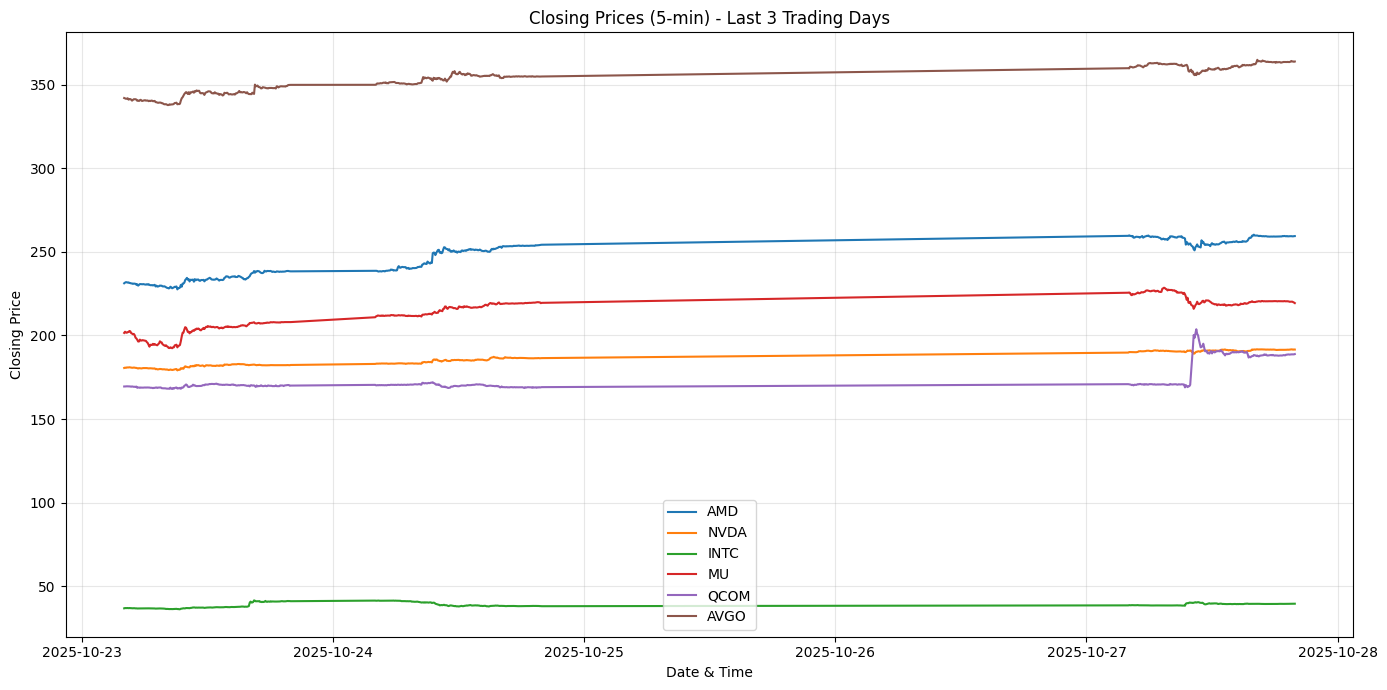


1. UNIT ROOT TEST (ADF) - STATIONARITY CHECK
AMD: ADF p-value = 0.790535 → Non-Stationary
NVDA: ADF p-value = 0.880895 → Non-Stationary
INTC: ADF p-value = 0.311517 → Non-Stationary
MU: ADF p-value = 0.694371 → Non-Stationary
QCOM: ADF p-value = 0.867212 → Non-Stationary
AVGO: ADF p-value = 0.790921 → Non-Stationary

1.5 ORDER OF INTEGRATION (how many differences to stationarity)
AMD: d = 1  (p-value after differencing = 0.000000) → Stationary
NVDA: d = 1  (p-value after differencing = 0.000000) → Stationary
INTC: d = 1  (p-value after differencing = 0.000000) → Stationary
MU: d = 1  (p-value after differencing = 0.000000) → Stationary
QCOM: d = 1  (p-value after differencing = 0.000000) → Stationary
AVGO: d = 1  (p-value after differencing = 0.000000) → Stationary

Summary of integration orders:
  AMD: I(1)
  NVDA: I(1)
  INTC: I(1)
  MU: I(1)
  QCOM: I(1)
  AVGO: I(1)

2. JOHANSEN COINTEGRATION TEST (PAIRWISE)
AMD vs NVDA: Trace Stat = 5.56, Crit(5%) = 15.49 → Not cointegrated
AMD v

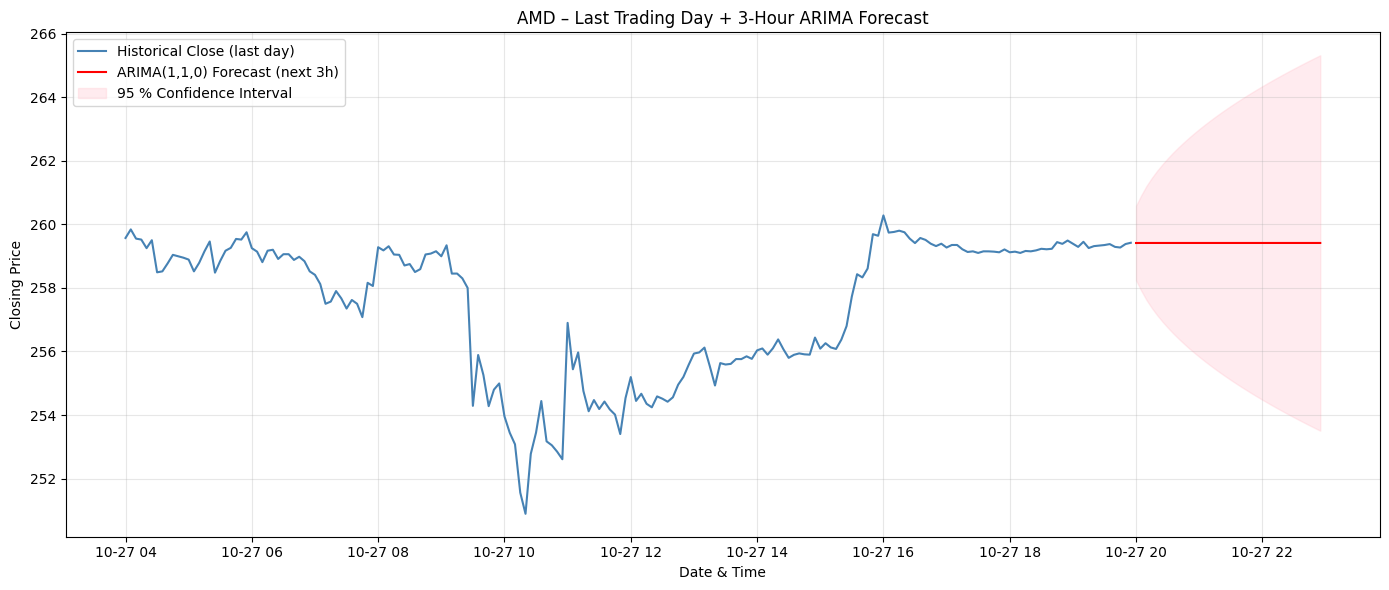


--- Processing NVDA ---
The results for the ARIMA(0,1,0) of NVDA are:
   AIC: -115.71
   Log-Likelihood: 58.86


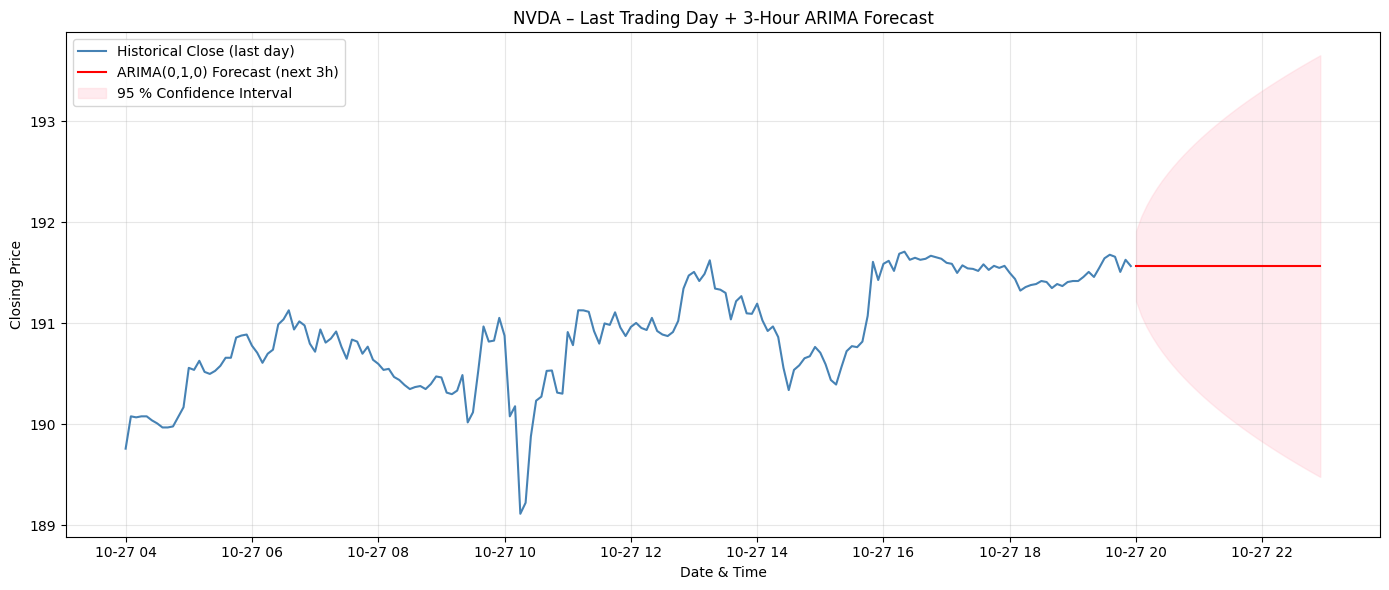


--- Processing INTC ---
The results for the ARIMA(2,1,2) of INTC are:
   AIC: -258.35
   Log-Likelihood: 134.18


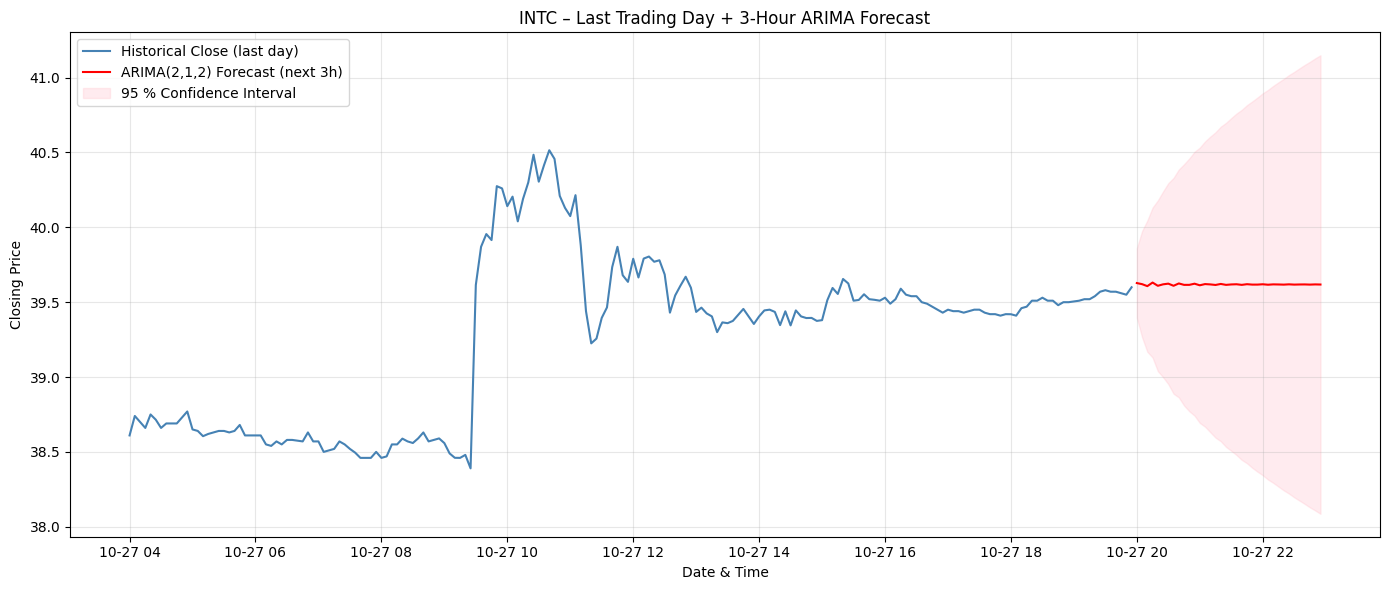


--- Processing MU ---
The results for the ARIMA(2,1,2) of MU are:
   AIC: 282.86
   Log-Likelihood: -136.43


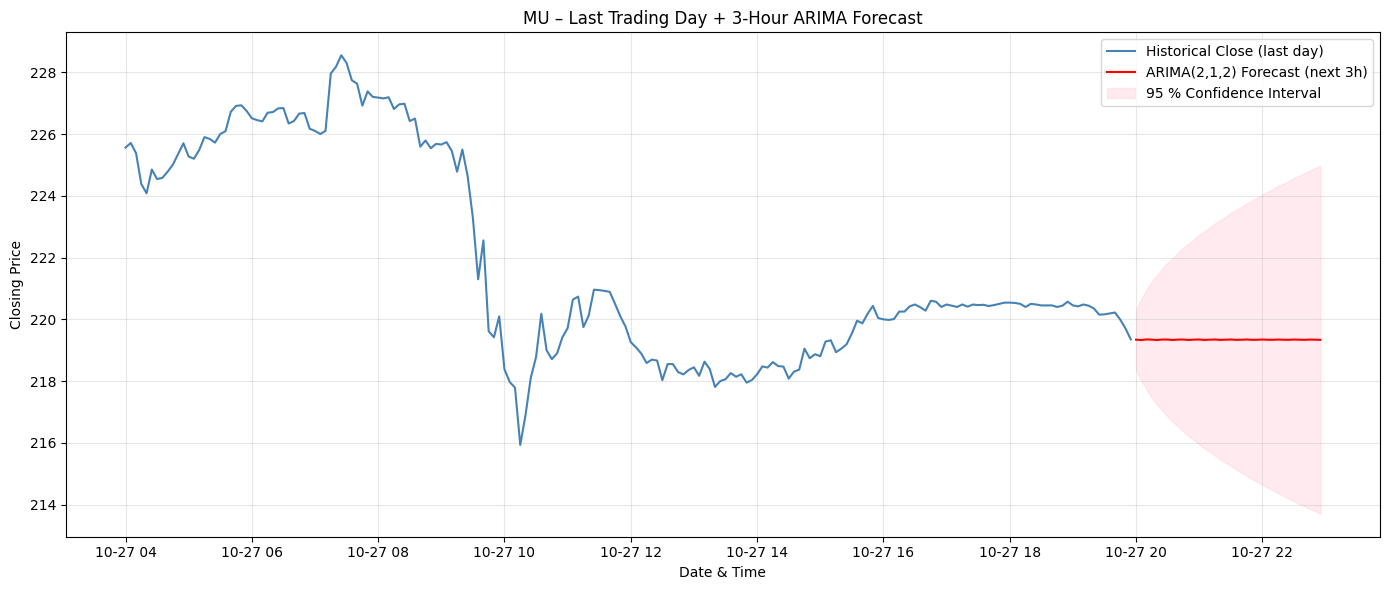


--- Processing QCOM ---
The results for the ARIMA(1,1,2) of QCOM are:
   AIC: 569.14
   Log-Likelihood: -280.57


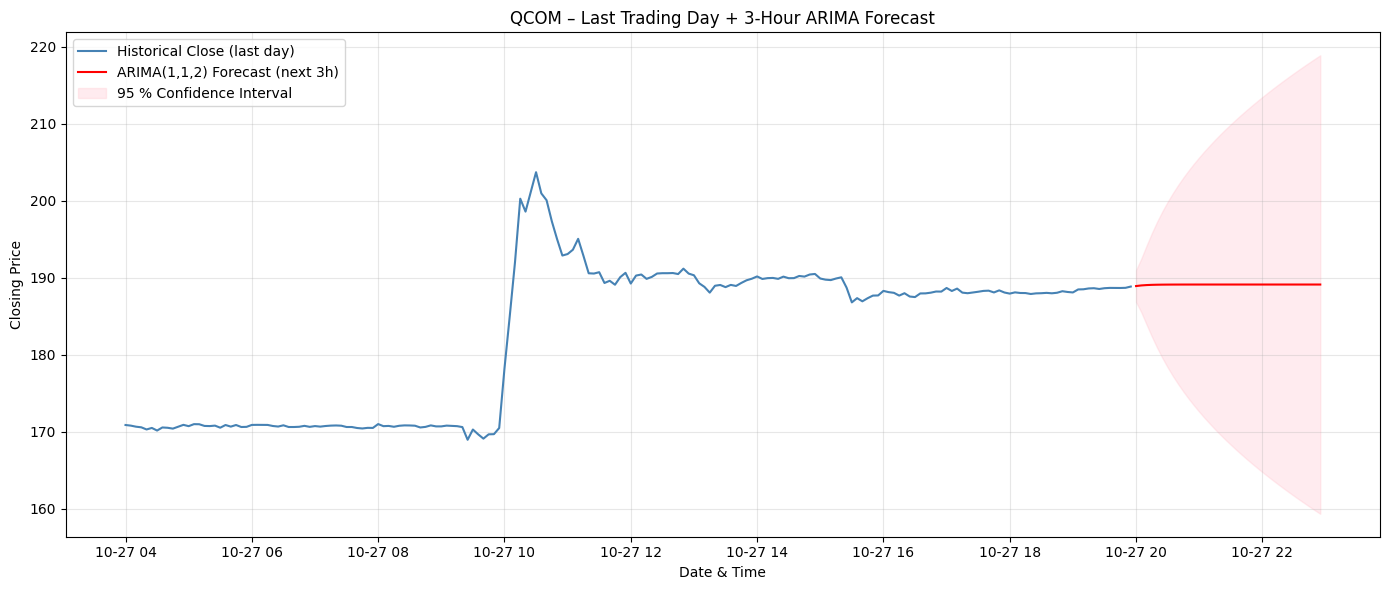


--- Processing AVGO ---
The results for the ARIMA(0,1,0) of AVGO are:
   AIC: 244.13
   Log-Likelihood: -121.07


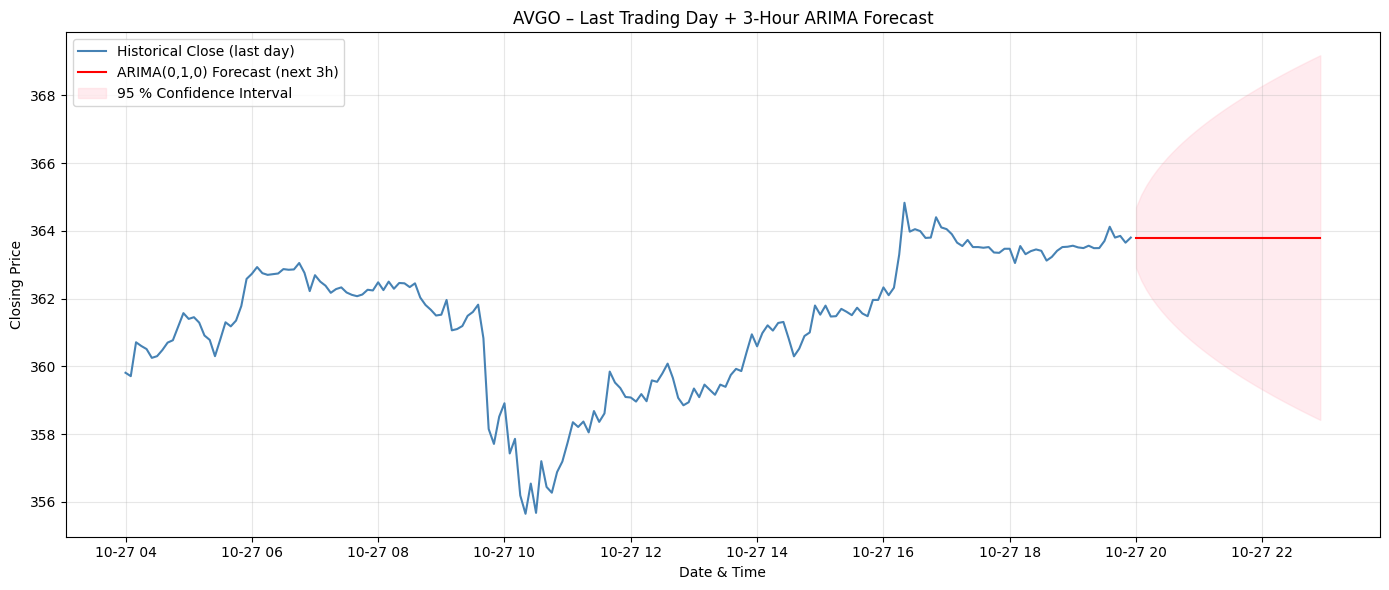

In [ ]:
# --------------------------------------------------------------
# 1. Install required packages (run once)
# --------------------------------------------------------------
!pip install -q alpha_vantage pandas matplotlib statsmodels scikit-learn

# --------------------------------------------------------------
# 2. Imports
# --------------------------------------------------------------
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.arima.model import ARIMA
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------------
# 3. USER INPUT – 6 tickers
# --------------------------------------------------------------
tickers_input = input("Enter 6 stock tickers separated by commas (e.g. NVDA,AMD,AAPL,MSFT,GOOGL,TSLA): ").strip().upper()
tickers = [t.strip() for t in tickers_input.split(',') if t.strip()]
if len(tickers) != 6:
    raise ValueError("Please enter exactly 6 tickers.")
print(f"Selected tickers: {', '.join(tickers)}")

# --------------------------------------------------------------
# 4. Alpha Vantage setup
# --------------------------------------------------------------
api_key = "3DF7XEQ6SA0N9J9G"  # replace with your own key if desired
ts = TimeSeries(key=api_key, output_format='pandas')

# --------------------------------------------------------------
# 5. Download 5-minute data for all 6 stocks
# --------------------------------------------------------------
print("\nDownloading 5-minute data for all stocks...")
data_dict = {}
for ticker in tickers:
    print(f"  Downloading {ticker}...")
    data, meta = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')
    data.columns = ['open', 'high', 'low', 'close', 'volume']
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    data_weekdays = data[data.index.weekday < 5]
    trading_days = data_weekdays.index.normalize().unique()[::-1]
    last_3_trading_days = sorted(trading_days[:3])
    if len(last_3_trading_days) < 3:
        print(f"Warning: Only {len(last_3_trading_days)} trading day(s) for {ticker}.")
        continue
    start_date = last_3_trading_days[0]
    end_date = last_3_trading_days[-1] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    last_3d = data_weekdays[start_date:end_date]
    data_dict[ticker] = last_3d['close'].copy()
    print(f"    {ticker}: {len(last_3d)} points from {last_3d.index.min()} to {last_3d.index.max()}")

# --------------------------------------------------------------
# 6. Align all series to same timestamp index
# --------------------------------------------------------------
print("\nAligning all time series to common timestamps...")
close_df = pd.DataFrame(data_dict)
close_df = close_df.dropna()  # Keep only timestamps where all 6 have data
print(f"Final aligned dataset: {len(close_df)} rows")

if len(close_df) == 0:
    raise ValueError("No overlapping timestamps across all 6 stocks.")

# --------------------------------------------------------------
# 7. Plot all closing prices in one line graph
# --------------------------------------------------------------
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_df.index, close_df[ticker], label=ticker)
plt.title('Closing Prices (5-min) - Last 3 Trading Days')
plt.xlabel('Date & Time')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 8. Unit Root Test (ADF) for stationarity
# --------------------------------------------------------------
print("\n" + "="*60)
print("1. UNIT ROOT TEST (ADF) - STATIONARITY CHECK")
print("="*60)
adf_results = {}
for ticker in tickers:
    series = close_df[ticker]
    result = adfuller(series)
    adf_results[ticker] = result
    p_value = result[1]
    print(f"{ticker}: ADF p-value = {p_value:.6f} → {'Stationary' if p_value < 0.05 else 'Non-Stationary'}")

# --------------------------------------------------------------
# 8.5 DETERMINE ORDER OF INTEGRATION (d) FOR EACH STOCK
# --------------------------------------------------------------
print("\n" + "="*60)
print("1.5 ORDER OF INTEGRATION (how many differences to stationarity)")
print("="*60)

def adf_pvalue(series):
    """Return ADF p-value (or 1.0 if error)"""
    try:
        return adfuller(series, maxlag=1, regression='c', autolag=None)[1]
    except:
        return 1.0

integration_order = {}

for ticker in tickers:
    series = close_df[ticker].copy()
    d = 0
    p_val = adf_pvalue(series)

    # keep differencing until p < 0.05 or d reaches a safe limit
    while p_val >= 0.05 and d < 3:          # stop at d=3 to avoid over-differencing
        d += 1
        series = series.diff().dropna()
        p_val = adf_pvalue(series)

    integration_order[ticker] = d
    status = "Stationary" if p_val < 0.05 else "Still Non-Stationary"
    print(f"{ticker}: d = {d}  (p-value after differencing = {p_val:.6f}) → {status}")

print("\nSummary of integration orders:")
for ticker, d in integration_order.items():
    print(f"  {ticker}: I({d})")

# --------------------------------------------------------------
# 9. Johansen Cointegration Test (pairwise)
# --------------------------------------------------------------
print("\n" + "="*60)
print("2. JOHANSEN COINTEGRATION TEST (PAIRWISE)")
print("="*60)

pair_combinations = list(combinations(tickers, 2))
cointegration_results = []

for pair in pair_combinations:
    t1, t2 = pair
    data_pair = close_df[[t1, t2]].dropna()
    if len(data_pair) < 50:
        print(f"Skipping {t1}-{t2}: insufficient data ({len(data_pair)} points)")
        continue
    try:
        johansen_result = coint_johansen(data_pair, det_order=0, k_ar_diff=1)
        trace_stat = johansen_result.lr1[0]  # Test for r=0 vs r>=1
        critical_value = johansen_result.cvt[0, 1]  # 5% critical value
        p_value = johansen_result.lr1[0]  # Approximate p-value not directly given
        is_cointegrated = trace_stat > critical_value
        cointegration_results.append((t1, t2, trace_stat, critical_value, is_cointegrated))
        status = "COINTEGRATED" if is_cointegrated else "Not cointegrated"
        print(f"{t1} vs {t2}: Trace Stat = {trace_stat:.2f}, Crit(5%) = {critical_value:.2f} → {status}")
    except Exception as e:
        print(f"Error testing {t1}-{t2}: {e}")

# --------------------------------------------------------------
# 10. ARIMA Modeling + Forecasting + Plot per stock (LAST DAY ONLY)
# --------------------------------------------------------------
print("\n" + "="*60)
print("3. ARIMA MODELING & FORECASTING (last trading day only)")
print("="*60)

# 3 hours = 36 × 5-min steps
forecast_steps = 36          # changed from 12

for ticker in tickers:
    print(f"\n--- Processing {ticker} ---")
    series = close_df[ticker].copy()

    # ------------------------------------------------------
    # 1. Keep only the last trading day
    # ------------------------------------------------------
    last_day = series.index.normalize()[-1]
    series_last_day = series[series.index.normalize() == last_day]

    # ------------------------------------------------------
    # 2. Auto-select ARIMA(p,d,q) – small grid (fast)
    # ------------------------------------------------------
    best_aic = np.inf
    best_order = None
    best_model = None

    for d in [0, 1]:
        diff_series = series_last_day.diff(d).dropna() if d > 0 else series_last_day
        for p in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(series_last_day, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        best_model = fitted
                except Exception:
                    continue

    if best_model is None:
        print(f"Could not fit ARIMA for {ticker}. Skipping.")
        continue

    p, d, q = best_order
    print(f"The results for the ARIMA({p},{d},{q}) of {ticker} are:")
    print(f"   AIC: {best_aic:.2f}")
    print(f"   Log-Likelihood: {best_model.llf:.2f}")

    # ------------------------------------------------------
    # 3. Forecast & confidence interval
    # ------------------------------------------------------
    forecast_result = best_model.get_forecast(steps=forecast_steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)

    # Future timestamps (5-min steps after the last observation)
    last_time = series_last_day.index[-1]
    future_index = pd.date_range(start=last_time + pd.Timedelta(minutes=5),
                                 periods=forecast_steps, freq='5min')

    # ------------------------------------------------------
    # 4. Plot last day + 3-hour forecast + 95 % CI
    # ------------------------------------------------------
    plt.figure(figsize=(14, 6))                     # a bit wider for longer horizon
    plt.plot(series_last_day.index, series_last_day,
             label='Historical Close (last day)', color='steelblue')
    plt.plot(future_index, forecast,
             label=f'ARIMA({p},{d},{q}) Forecast (next 3h)', color='red')
    plt.fill_between(future_index,
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     color='pink', alpha=0.3,
                     label='95 % Confidence Interval')

    plt.title(f'{ticker} – Last Trading Day + 3-Hour ARIMA Forecast')
    plt.xlabel('Date & Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Forecast para 6 acciones día 2: 29/10/2025

Enter 6 stock tickers separated by commas (e.g. NVDA,AMD,AAPL,MSFT,GOOGL,TSLA): AMD, NVDA, INTC, MU, QCOM, AVGO
Selected tickers: AMD, NVDA, INTC, MU, QCOM, AVGO

    AMD: 576 points from 2025-10-24 04:00:00 to 2025-10-28 19:55:00
    NVDA: 576 points from 2025-10-24 04:00:00 to 2025-10-28 19:55:00
    INTC: 576 points from 2025-10-24 04:00:00 to 2025-10-28 19:55:00
    MU: 576 points from 2025-10-24 04:00:00 to 2025-10-28 19:55:00
    QCOM: 575 points from 2025-10-24 04:00:00 to 2025-10-28 19:55:00
    AVGO: 576 points from 2025-10-24 04:00:00 to 2025-10-28 19:55:00

Aligning all time series to common timestamps...
Final aligned dataset: 575 rows


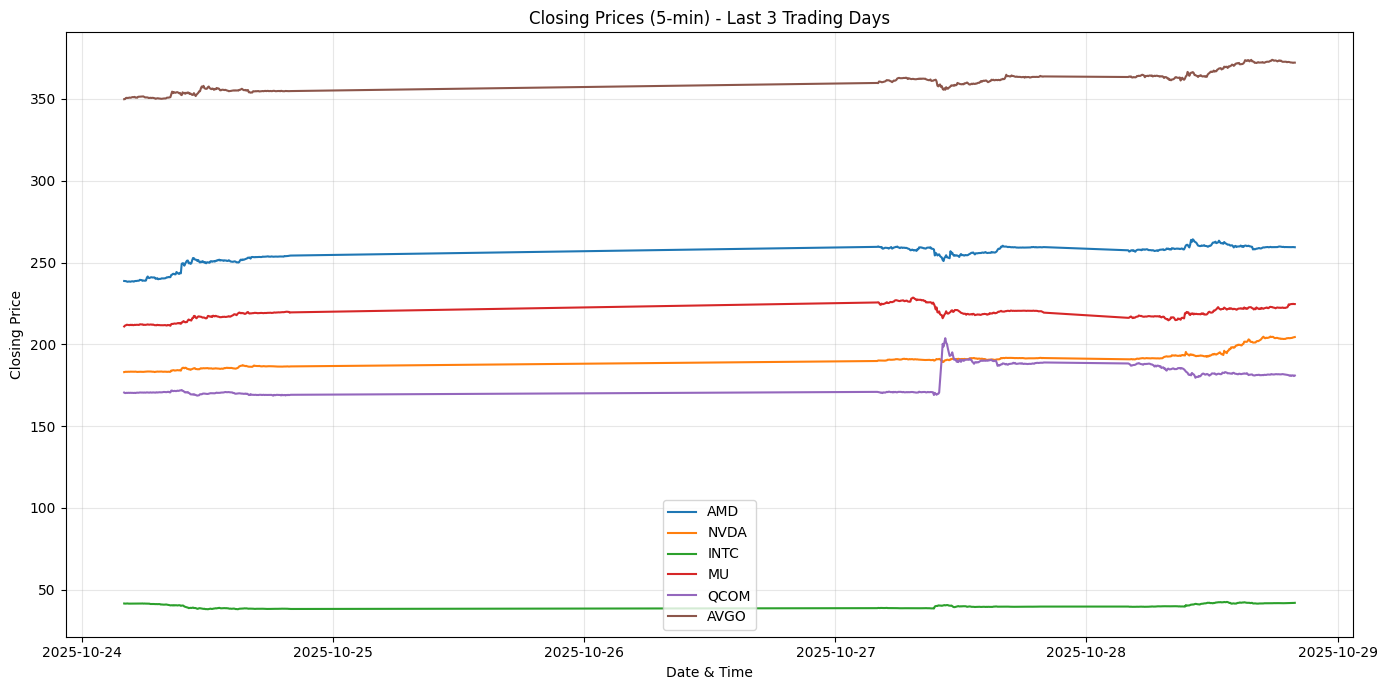


1. UNIT ROOT TEST (ADF) - STATIONARITY CHECK
AMD: ADF p-value = 0.059097 → Non-Stationary
NVDA: ADF p-value = 0.995023 → Non-Stationary
INTC: ADF p-value = 0.781305 → Non-Stationary
MU: ADF p-value = 0.301114 → Non-Stationary
QCOM: ADF p-value = 0.562779 → Non-Stationary
AVGO: ADF p-value = 0.803186 → Non-Stationary

1.5 ORDER OF INTEGRATION (how many differences to stationarity)
AMD: d = 1  (p-value after differencing = 0.000000) → Stationary
NVDA: d = 1  (p-value after differencing = 0.000000) → Stationary
INTC: d = 1  (p-value after differencing = 0.000000) → Stationary
MU: d = 1  (p-value after differencing = 0.000000) → Stationary
QCOM: d = 1  (p-value after differencing = 0.000000) → Stationary
AVGO: d = 1  (p-value after differencing = 0.000000) → Stationary

Summary of integration orders:
  AMD: I(1)
  NVDA: I(1)
  INTC: I(1)
  MU: I(1)
  QCOM: I(1)
  AVGO: I(1)

2. JOHANSEN COINTEGRATION TEST (PAIRWISE)
AMD vs NVDA: Trace Stat = 12.14, Crit(5%) = 15.49 → Not cointegrated
AMD 

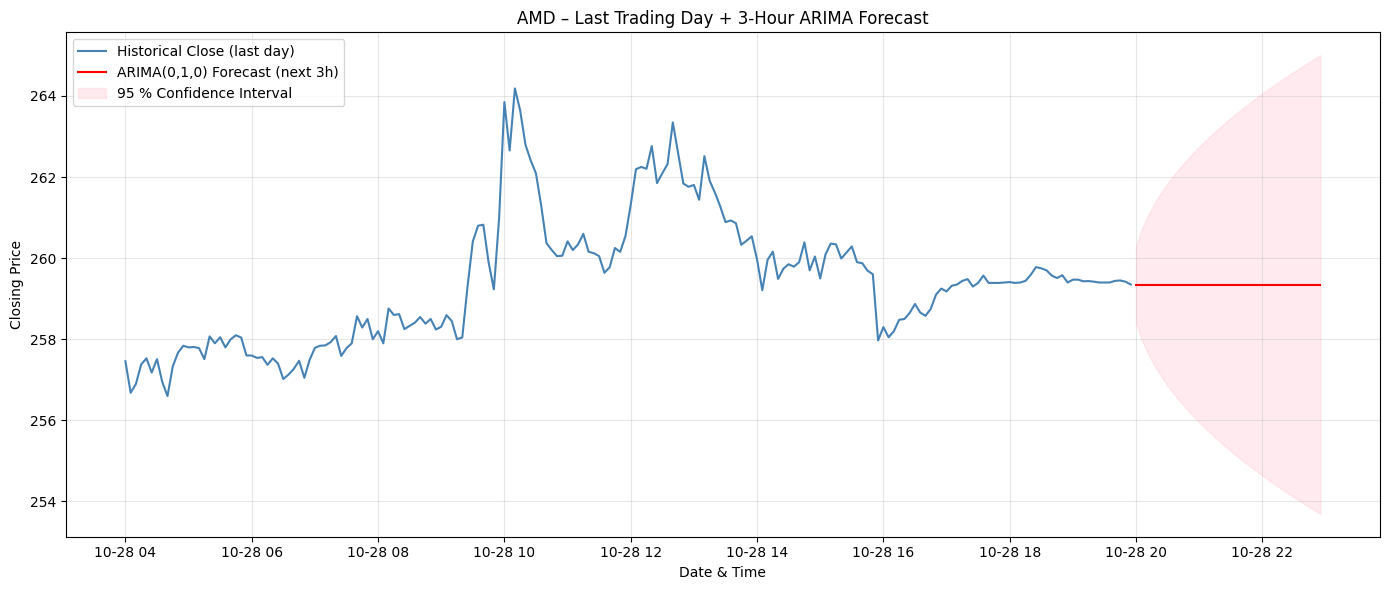


--- Processing NVDA ---
The results for the ARIMA(2,1,2) of NVDA are:
   AIC: 210.58
   Log-Likelihood: -100.29


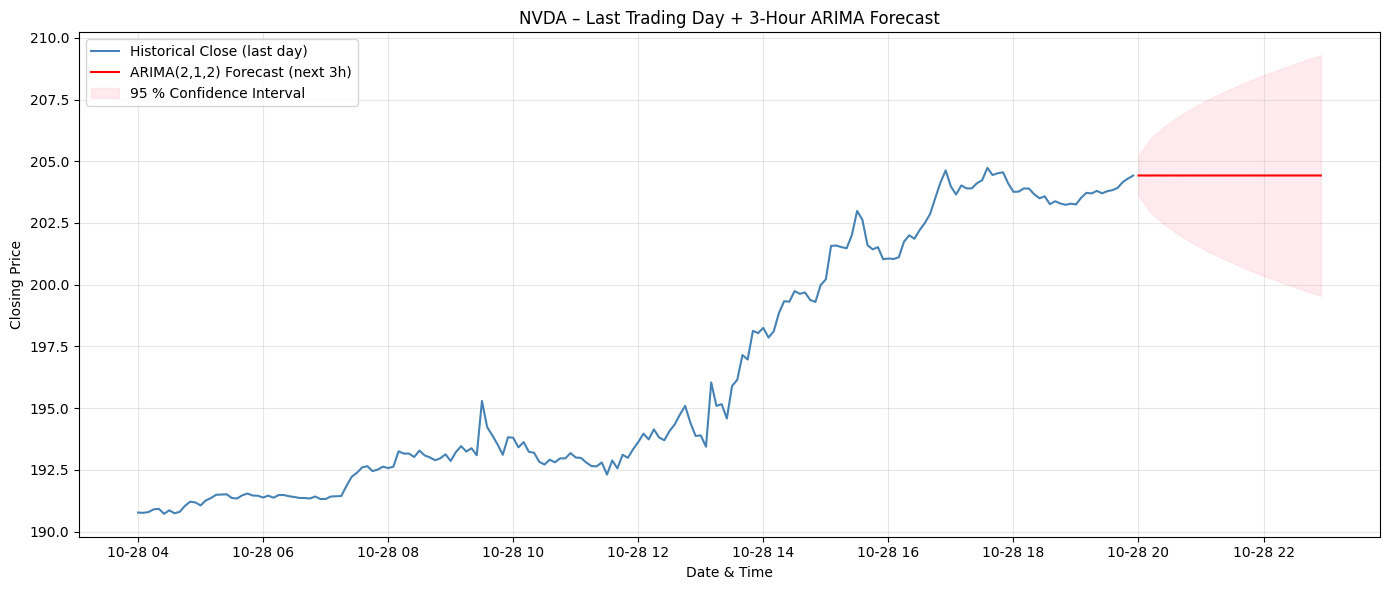


--- Processing INTC ---
The results for the ARIMA(0,1,2) of INTC are:
   AIC: -259.69
   Log-Likelihood: 132.85


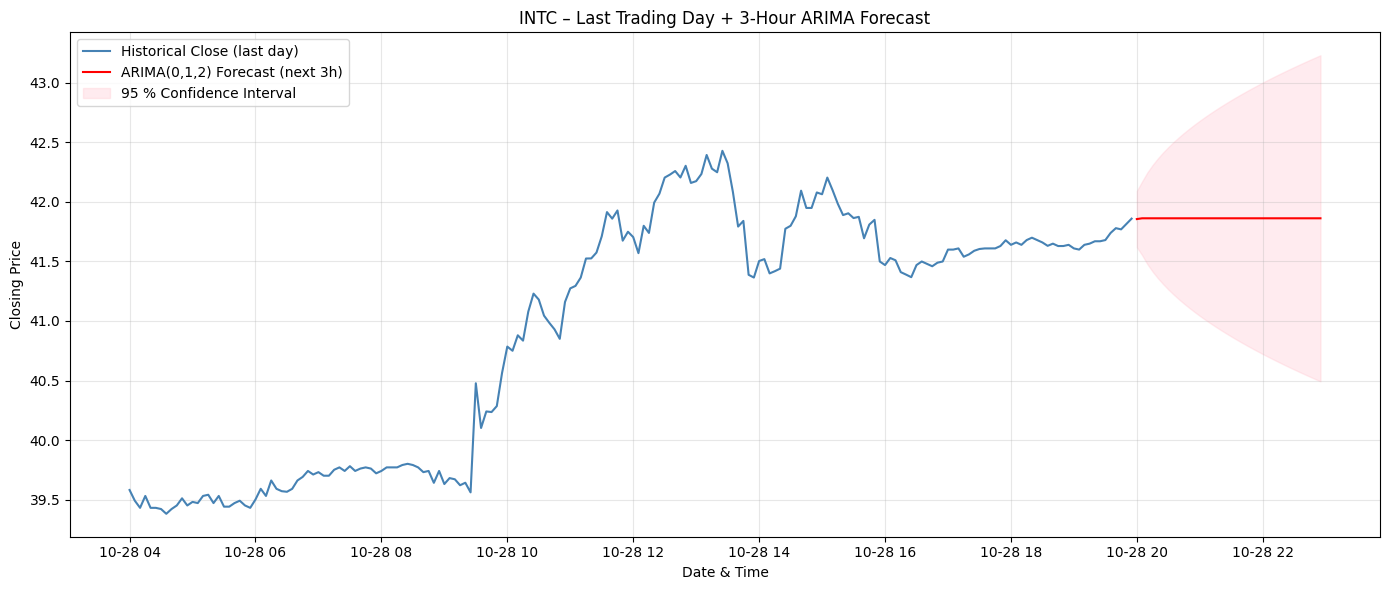


--- Processing MU ---
The results for the ARIMA(1,1,1) of MU are:
   AIC: 247.93
   Log-Likelihood: -120.96


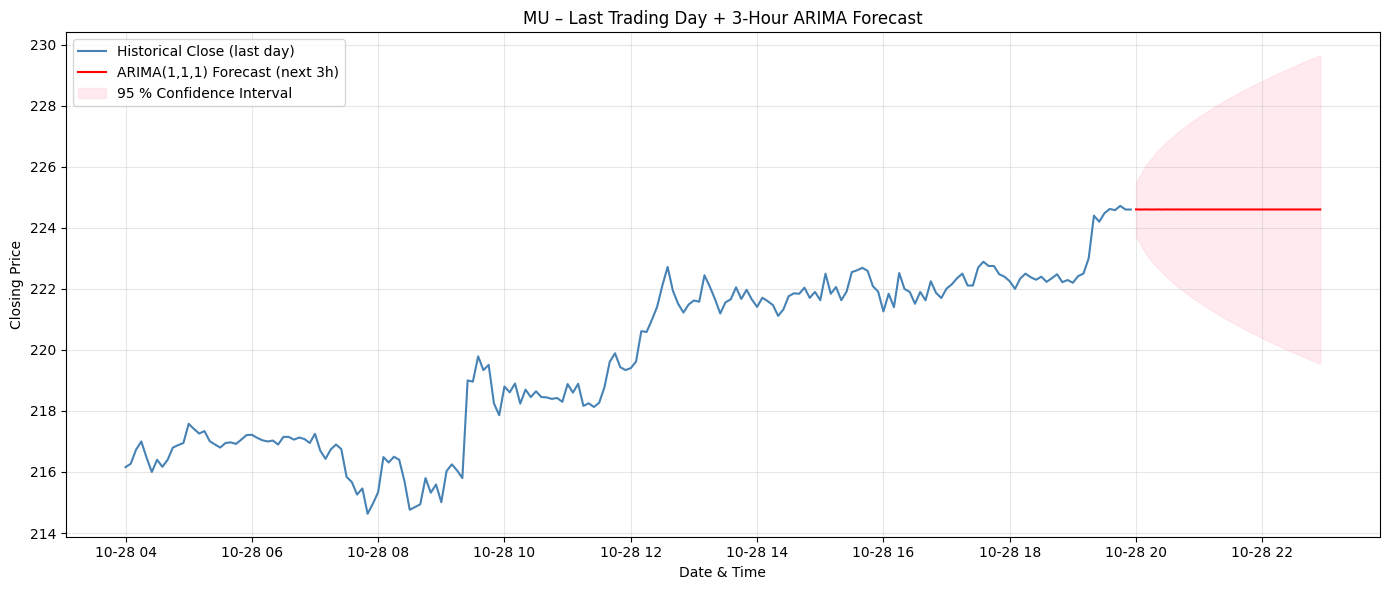


--- Processing QCOM ---
The results for the ARIMA(2,1,2) of QCOM are:
   AIC: 144.61
   Log-Likelihood: -67.30


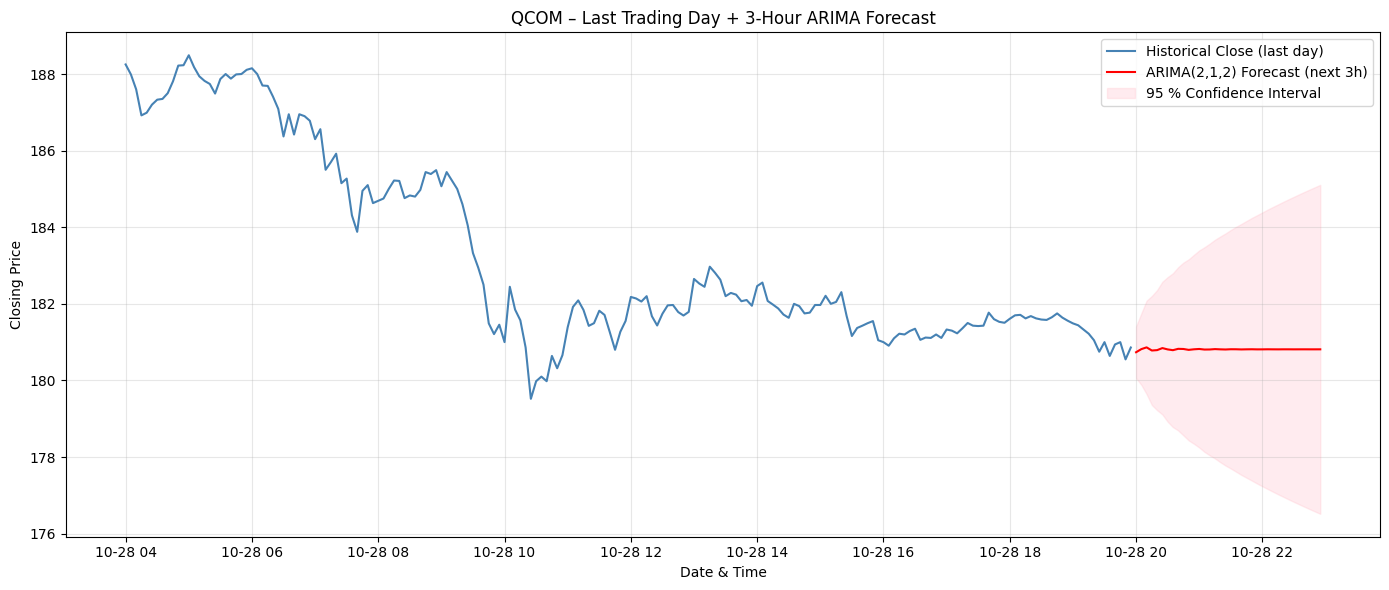


--- Processing AVGO ---
The results for the ARIMA(0,1,0) of AVGO are:
   AIC: 291.56
   Log-Likelihood: -144.78


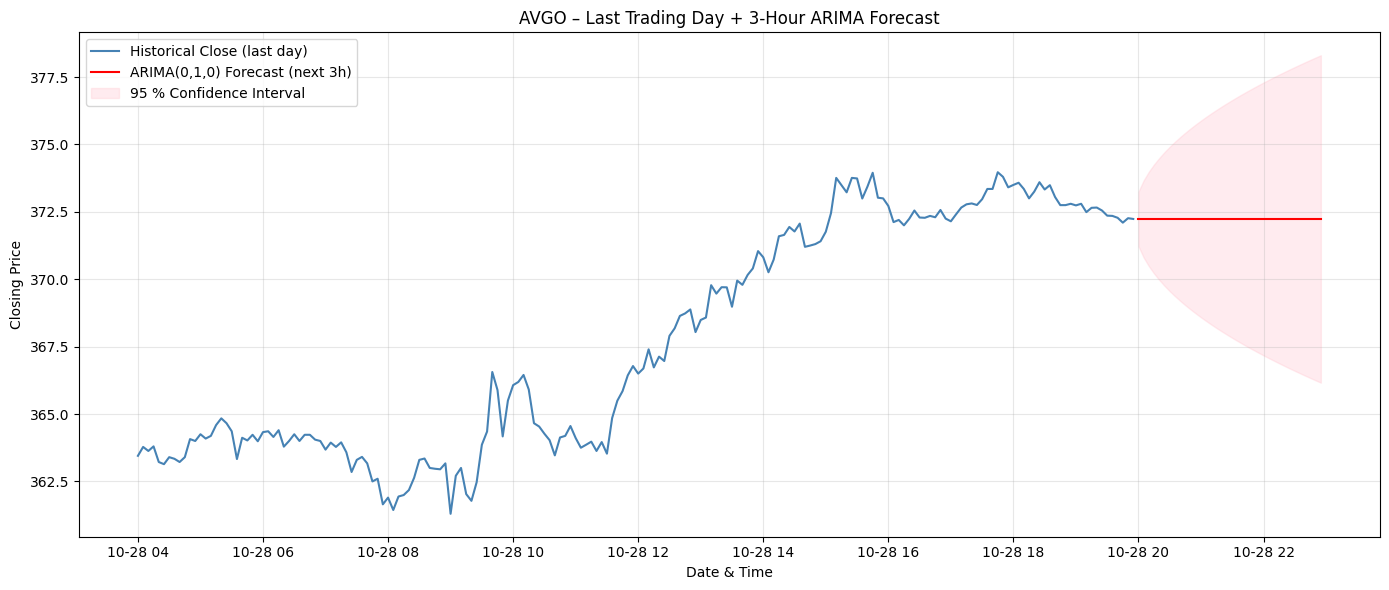

In [ ]:
# --------------------------------------------------------------
# 1. Install required packages (run once)
# --------------------------------------------------------------
!pip install -q alpha_vantage pandas matplotlib statsmodels scikit-learn

# --------------------------------------------------------------
# 2. Imports
# --------------------------------------------------------------
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.arima.model import ARIMA
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------------
# 3. USER INPUT – 6 tickers
# --------------------------------------------------------------
tickers_input = input("Enter 6 stock tickers separated by commas (e.g. NVDA,AMD,AAPL,MSFT,GOOGL,TSLA): ").strip().upper()
tickers = [t.strip() for t in tickers_input.split(',') if t.strip()]
if len(tickers) != 6:
    raise ValueError("Please enter exactly 6 tickers.")
print(f"Selected tickers: {', '.join(tickers)}")

# --------------------------------------------------------------
# 4. Alpha Vantage setup
# --------------------------------------------------------------
api_key = "3DF7XEQ6SA0N9J9G"  # replace with your own key if desired
ts = TimeSeries(key=api_key, output_format='pandas')

# --------------------------------------------------------------
# 5. Download 5-minute data for all 6 stocks
# --------------------------------------------------------------
print("\nDownloading 5-minute data for all stocks...")
data_dict = {}
for ticker in tickers:
    print(f"  Downloading {ticker}...")
    data, meta = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')
    data.columns = ['open', 'high', 'low', 'close', 'volume']
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    data_weekdays = data[data.index.weekday < 5]
    trading_days = data_weekdays.index.normalize().unique()[::-1]
    last_3_trading_days = sorted(trading_days[:3])
    if len(last_3_trading_days) < 3:
        print(f"Warning: Only {len(last_3_trading_days)} trading day(s) for {ticker}.")
        continue
    start_date = last_3_trading_days[0]
    end_date = last_3_trading_days[-1] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    last_3d = data_weekdays[start_date:end_date]
    data_dict[ticker] = last_3d['close'].copy()
    print(f"    {ticker}: {len(last_3d)} points from {last_3d.index.min()} to {last_3d.index.max()}")

# --------------------------------------------------------------
# 6. Align all series to same timestamp index
# --------------------------------------------------------------
print("\nAligning all time series to common timestamps...")
close_df = pd.DataFrame(data_dict)
close_df = close_df.dropna()  # Keep only timestamps where all 6 have data
print(f"Final aligned dataset: {len(close_df)} rows")

if len(close_df) == 0:
    raise ValueError("No overlapping timestamps across all 6 stocks.")

# --------------------------------------------------------------
# 7. Plot all closing prices in one line graph
# --------------------------------------------------------------
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_df.index, close_df[ticker], label=ticker)
plt.title('Closing Prices (5-min) - Last 3 Trading Days')
plt.xlabel('Date & Time')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 8. Unit Root Test (ADF) for stationarity
# --------------------------------------------------------------
print("\n" + "="*60)
print("1. UNIT ROOT TEST (ADF) - STATIONARITY CHECK")
print("="*60)
adf_results = {}
for ticker in tickers:
    series = close_df[ticker]
    result = adfuller(series)
    adf_results[ticker] = result
    p_value = result[1]
    print(f"{ticker}: ADF p-value = {p_value:.6f} → {'Stationary' if p_value < 0.05 else 'Non-Stationary'}")

# --------------------------------------------------------------
# 8.5 DETERMINE ORDER OF INTEGRATION (d) FOR EACH STOCK
# --------------------------------------------------------------
print("\n" + "="*60)
print("1.5 ORDER OF INTEGRATION (how many differences to stationarity)")
print("="*60)

def adf_pvalue(series):
    """Return ADF p-value (or 1.0 if error)"""
    try:
        return adfuller(series, maxlag=1, regression='c', autolag=None)[1]
    except:
        return 1.0

integration_order = {}

for ticker in tickers:
    series = close_df[ticker].copy()
    d = 0
    p_val = adf_pvalue(series)

    # keep differencing until p < 0.05 or d reaches a safe limit
    while p_val >= 0.05 and d < 3:          # stop at d=3 to avoid over-differencing
        d += 1
        series = series.diff().dropna()
        p_val = adf_pvalue(series)

    integration_order[ticker] = d
    status = "Stationary" if p_val < 0.05 else "Still Non-Stationary"
    print(f"{ticker}: d = {d}  (p-value after differencing = {p_val:.6f}) → {status}")

print("\nSummary of integration orders:")
for ticker, d in integration_order.items():
    print(f"  {ticker}: I({d})")

# --------------------------------------------------------------
# 9. Johansen Cointegration Test (pairwise)
# --------------------------------------------------------------
print("\n" + "="*60)
print("2. JOHANSEN COINTEGRATION TEST (PAIRWISE)")
print("="*60)

pair_combinations = list(combinations(tickers, 2))
cointegration_results = []

for pair in pair_combinations:
    t1, t2 = pair
    data_pair = close_df[[t1, t2]].dropna()
    if len(data_pair) < 50:
        print(f"Skipping {t1}-{t2}: insufficient data ({len(data_pair)} points)")
        continue
    try:
        johansen_result = coint_johansen(data_pair, det_order=0, k_ar_diff=1)
        trace_stat = johansen_result.lr1[0]  # Test for r=0 vs r>=1
        critical_value = johansen_result.cvt[0, 1]  # 5% critical value
        p_value = johansen_result.lr1[0]  # Approximate p-value not directly given
        is_cointegrated = trace_stat > critical_value
        cointegration_results.append((t1, t2, trace_stat, critical_value, is_cointegrated))
        status = "COINTEGRATED" if is_cointegrated else "Not cointegrated"
        print(f"{t1} vs {t2}: Trace Stat = {trace_stat:.2f}, Crit(5%) = {critical_value:.2f} → {status}")
    except Exception as e:
        print(f"Error testing {t1}-{t2}: {e}")

# --------------------------------------------------------------
# 10. ARIMA Modeling + Forecasting + Plot per stock (LAST DAY ONLY)
# --------------------------------------------------------------
print("\n" + "="*60)
print("3. ARIMA MODELING & FORECASTING (last trading day only)")
print("="*60)

# 3 hours = 36 × 5-min steps
forecast_steps = 36          # changed from 12

for ticker in tickers:
    print(f"\n--- Processing {ticker} ---")
    series = close_df[ticker].copy()

    # ------------------------------------------------------
    # 1. Keep only the last trading day
    # ------------------------------------------------------
    last_day = series.index.normalize()[-1]
    series_last_day = series[series.index.normalize() == last_day]

    # ------------------------------------------------------
    # 2. Auto-select ARIMA(p,d,q) – small grid (fast)
    # ------------------------------------------------------
    best_aic = np.inf
    best_order = None
    best_model = None

    for d in [0, 1]:
        diff_series = series_last_day.diff(d).dropna() if d > 0 else series_last_day
        for p in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(series_last_day, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        best_model = fitted
                except Exception:
                    continue

    if best_model is None:
        print(f"Could not fit ARIMA for {ticker}. Skipping.")
        continue

    p, d, q = best_order
    print(f"The results for the ARIMA({p},{d},{q}) of {ticker} are:")
    print(f"   AIC: {best_aic:.2f}")
    print(f"   Log-Likelihood: {best_model.llf:.2f}")

    # ------------------------------------------------------
    # 3. Forecast & confidence interval
    # ------------------------------------------------------
    forecast_result = best_model.get_forecast(steps=forecast_steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)

    # Future timestamps (5-min steps after the last observation)
    last_time = series_last_day.index[-1]
    future_index = pd.date_range(start=last_time + pd.Timedelta(minutes=5),
                                 periods=forecast_steps, freq='5min')

    # ------------------------------------------------------
    # 4. Plot last day + 3-hour forecast + 95 % CI
    # ------------------------------------------------------
    plt.figure(figsize=(14, 6))                     # a bit wider for longer horizon
    plt.plot(series_last_day.index, series_last_day,
             label='Historical Close (last day)', color='steelblue')
    plt.plot(future_index, forecast,
             label=f'ARIMA({p},{d},{q}) Forecast (next 3h)', color='red')
    plt.fill_between(future_index,
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     color='pink', alpha=0.3,
                     label='95 % Confidence Interval')

    plt.title(f'{ticker} – Last Trading Day + 3-Hour ARIMA Forecast')
    plt.xlabel('Date & Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Forecast para 6 acciones día 3: 30/10/2025

Enter 6 stock tickers separated by commas (e.g. NVDA,AMD,AAPL,MSFT,GOOGL,TSLA): AMD, NVDA, INTC, MU, QCOM, AVGO
Selected tickers: AMD, NVDA, INTC, MU, QCOM, AVGO

    AMD: 576 points from 2025-10-27 04:00:00 to 2025-10-29 19:55:00
    NVDA: 576 points from 2025-10-27 04:00:00 to 2025-10-29 19:55:00
    INTC: 576 points from 2025-10-27 04:00:00 to 2025-10-29 19:55:00
    MU: 576 points from 2025-10-27 04:00:00 to 2025-10-29 19:55:00
    QCOM: 575 points from 2025-10-27 04:00:00 to 2025-10-29 19:55:00
    AVGO: 576 points from 2025-10-27 04:00:00 to 2025-10-29 19:55:00

Aligning all time series to common timestamps...
Final aligned dataset: 575 rows


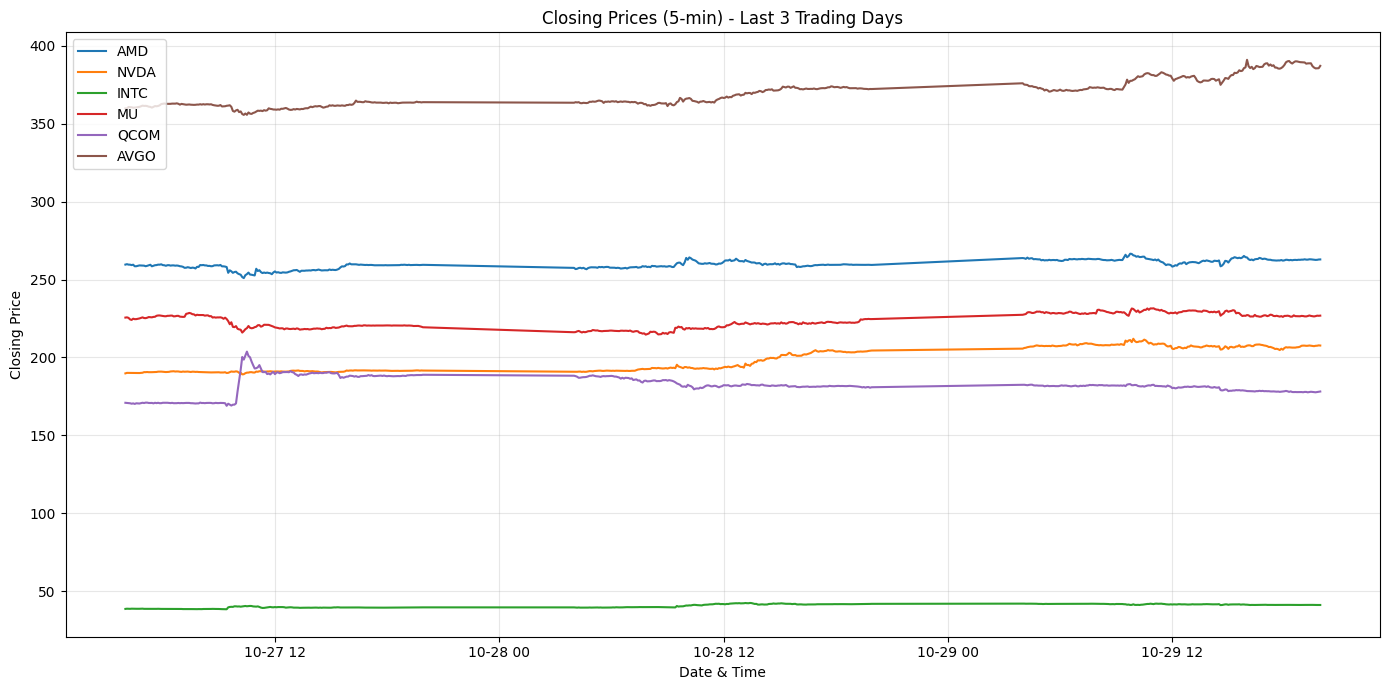


1. UNIT ROOT TEST (ADF) - STATIONARITY CHECK
AMD: ADF p-value = 0.178330 → Non-Stationary
NVDA: ADF p-value = 0.893091 → Non-Stationary
INTC: ADF p-value = 0.423372 → Non-Stationary
MU: ADF p-value = 0.588625 → Non-Stationary
QCOM: ADF p-value = 0.123390 → Non-Stationary
AVGO: ADF p-value = 0.943889 → Non-Stationary

1.5 ORDER OF INTEGRATION (how many differences to stationarity)
AMD: d = 1  (p-value after differencing = 0.000000) → Stationary
NVDA: d = 1  (p-value after differencing = 0.000000) → Stationary
INTC: d = 1  (p-value after differencing = 0.000000) → Stationary
MU: d = 1  (p-value after differencing = 0.000000) → Stationary
QCOM: d = 0  (p-value after differencing = 0.046095) → Stationary
AVGO: d = 1  (p-value after differencing = 0.000000) → Stationary

Summary of integration orders:
  AMD: I(1)
  NVDA: I(1)
  INTC: I(1)
  MU: I(1)
  QCOM: I(0)
  AVGO: I(1)

2. JOHANSEN COINTEGRATION TEST (PAIRWISE)
AMD vs NVDA: Trace Stat = 13.51, Crit(5%) = 15.49 → Not cointegrated
AMD 

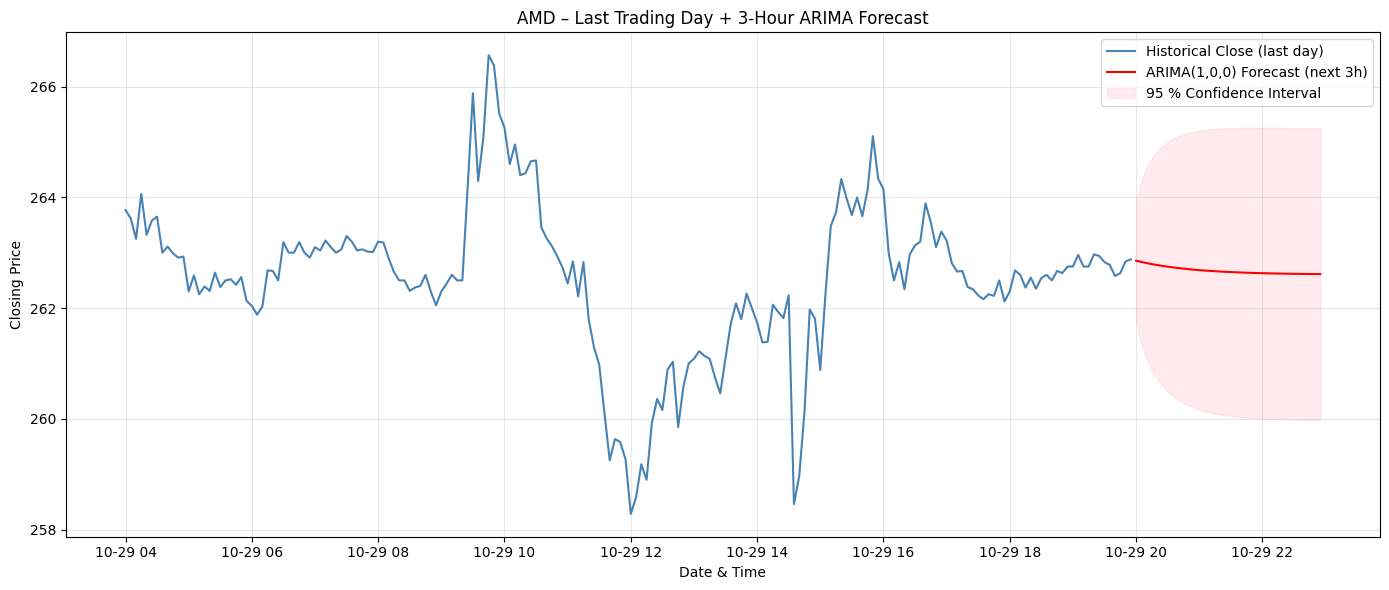


--- Processing NVDA ---
The results for the ARIMA(2,1,1) of NVDA are:
   AIC: 289.98
   Log-Likelihood: -140.99


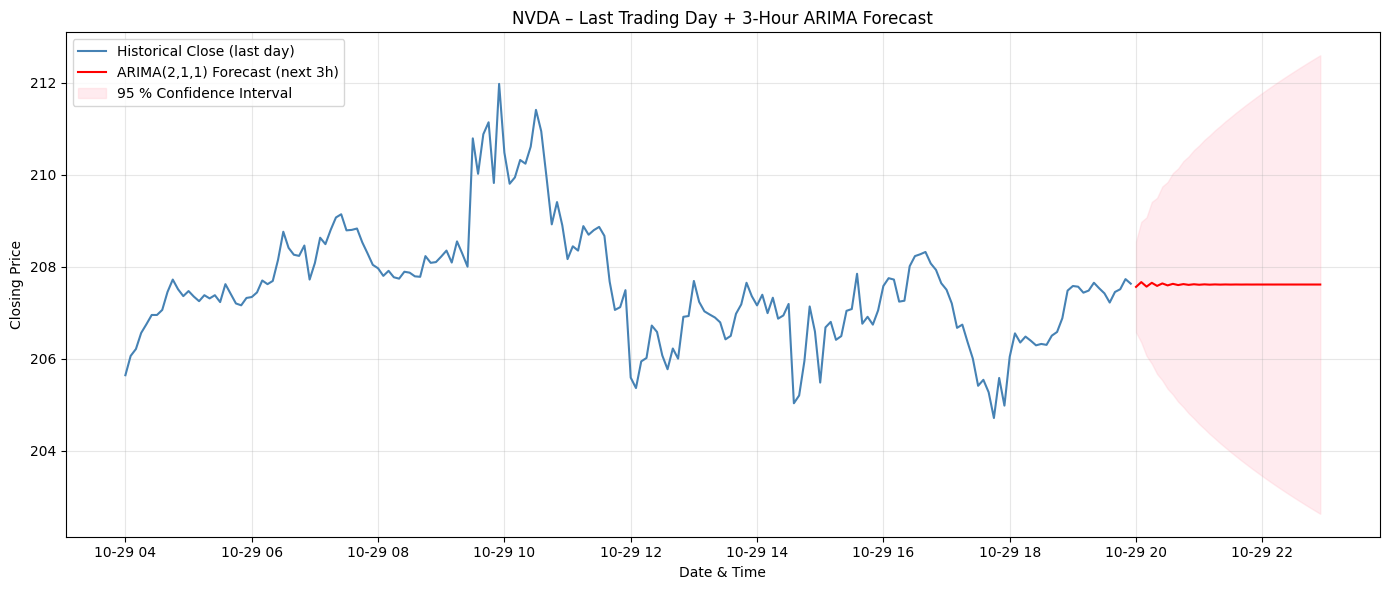


--- Processing INTC ---
The results for the ARIMA(1,1,2) of INTC are:
   AIC: -359.02
   Log-Likelihood: 183.51


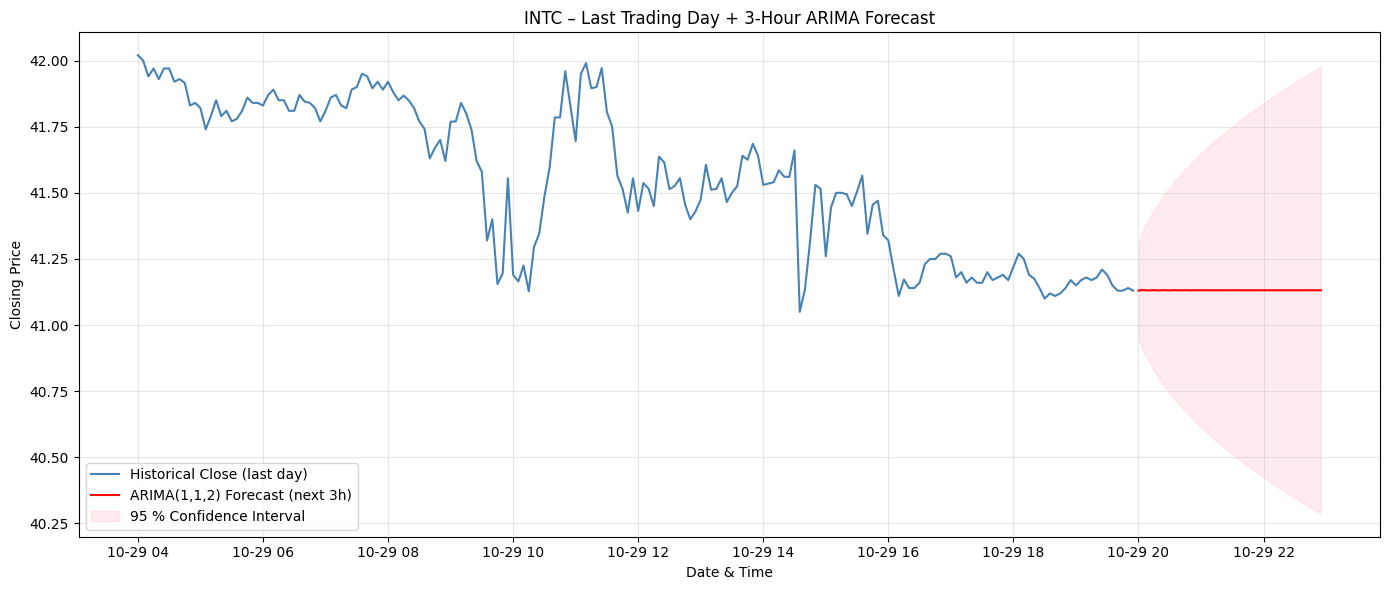


--- Processing MU ---
The results for the ARIMA(1,1,1) of MU are:
   AIC: 330.86
   Log-Likelihood: -162.43


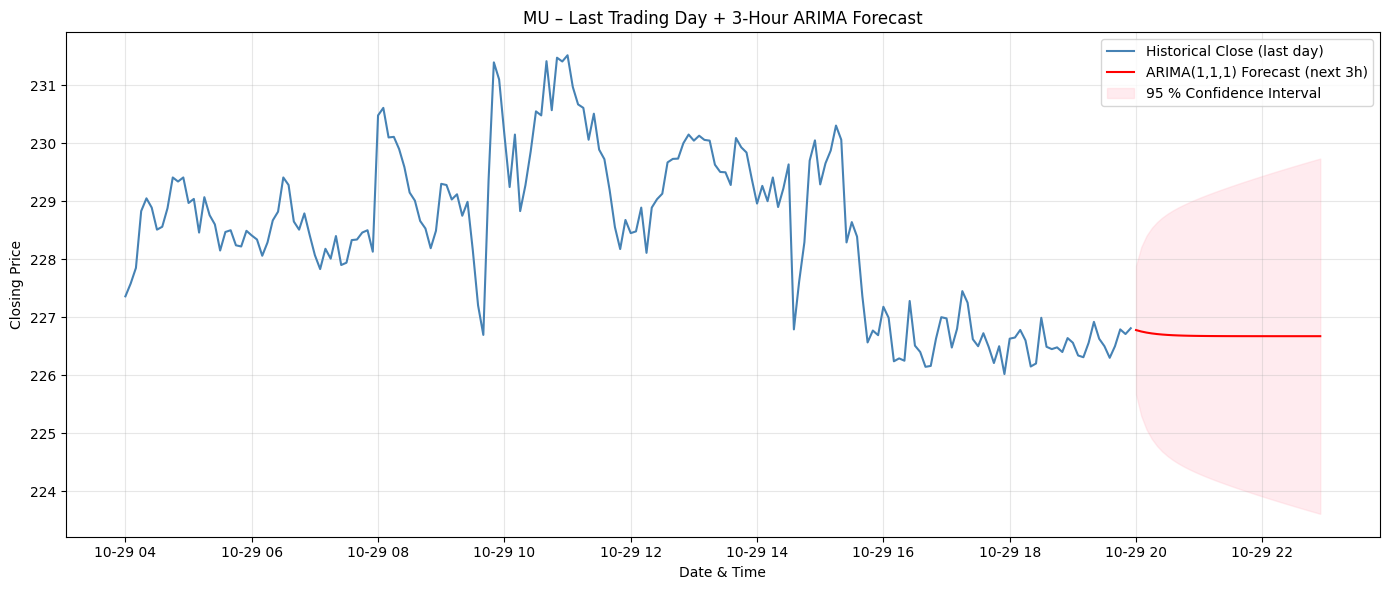


--- Processing QCOM ---
The results for the ARIMA(0,1,1) of QCOM are:
   AIC: 56.43
   Log-Likelihood: -26.22


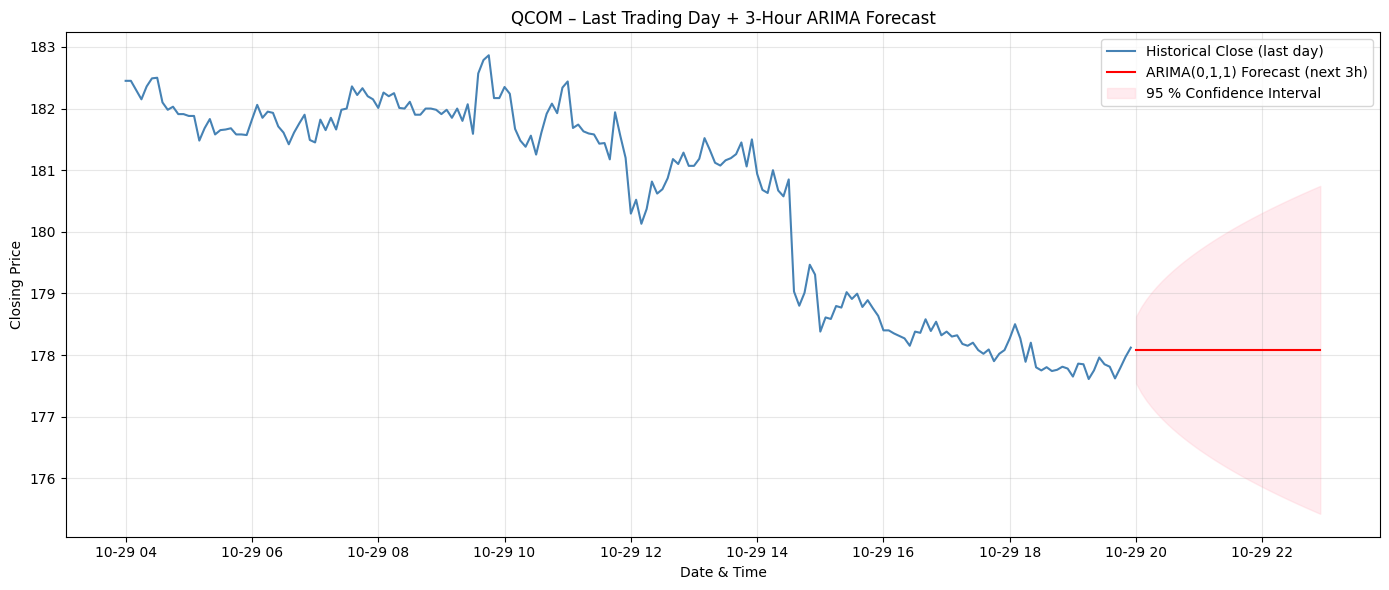


--- Processing AVGO ---
The results for the ARIMA(0,1,0) of AVGO are:
   AIC: 508.45
   Log-Likelihood: -253.23


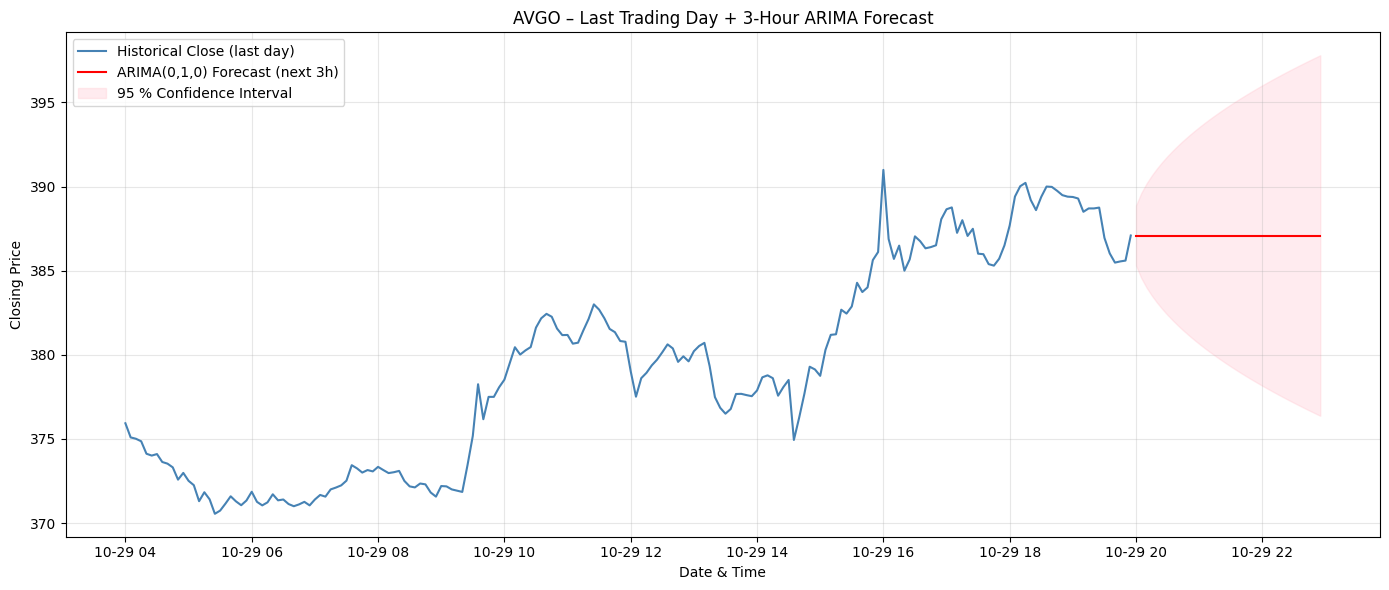

In [ ]:
# --------------------------------------------------------------
# 1. Install required packages (run once)
# --------------------------------------------------------------
!pip install -q alpha_vantage pandas matplotlib statsmodels scikit-learn

# --------------------------------------------------------------
# 2. Imports
# --------------------------------------------------------------
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.arima.model import ARIMA
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------------
# 3. USER INPUT – 6 tickers
# --------------------------------------------------------------
tickers_input = input("Enter 6 stock tickers separated by commas (e.g. NVDA,AMD,AAPL,MSFT,GOOGL,TSLA): ").strip().upper()
tickers = [t.strip() for t in tickers_input.split(',') if t.strip()]
if len(tickers) != 6:
    raise ValueError("Please enter exactly 6 tickers.")
print(f"Selected tickers: {', '.join(tickers)}")

# --------------------------------------------------------------
# 4. Alpha Vantage setup
# --------------------------------------------------------------
api_key = "3DF7XEQ6SA0N9J9G"  # replace with your own key if desired
ts = TimeSeries(key=api_key, output_format='pandas')

# --------------------------------------------------------------
# 5. Download 5-minute data for all 6 stocks
# --------------------------------------------------------------
print("\nDownloading 5-minute data for all stocks...")
data_dict = {}
for ticker in tickers:
    print(f"  Downloading {ticker}...")
    data, meta = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')
    data.columns = ['open', 'high', 'low', 'close', 'volume']
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    data_weekdays = data[data.index.weekday < 5]
    trading_days = data_weekdays.index.normalize().unique()[::-1]
    last_3_trading_days = sorted(trading_days[:3])
    if len(last_3_trading_days) < 3:
        print(f"Warning: Only {len(last_3_trading_days)} trading day(s) for {ticker}.")
        continue
    start_date = last_3_trading_days[0]
    end_date = last_3_trading_days[-1] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    last_3d = data_weekdays[start_date:end_date]
    data_dict[ticker] = last_3d['close'].copy()
    print(f"    {ticker}: {len(last_3d)} points from {last_3d.index.min()} to {last_3d.index.max()}")

# --------------------------------------------------------------
# 6. Align all series to same timestamp index
# --------------------------------------------------------------
print("\nAligning all time series to common timestamps...")
close_df = pd.DataFrame(data_dict)
close_df = close_df.dropna()  # Keep only timestamps where all 6 have data
print(f"Final aligned dataset: {len(close_df)} rows")

if len(close_df) == 0:
    raise ValueError("No overlapping timestamps across all 6 stocks.")

# --------------------------------------------------------------
# 7. Plot all closing prices in one line graph
# --------------------------------------------------------------
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_df.index, close_df[ticker], label=ticker)
plt.title('Closing Prices (5-min) - Last 3 Trading Days')
plt.xlabel('Date & Time')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 8. Unit Root Test (ADF) for stationarity
# --------------------------------------------------------------
print("\n" + "="*60)
print("1. UNIT ROOT TEST (ADF) - STATIONARITY CHECK")
print("="*60)
adf_results = {}
for ticker in tickers:
    series = close_df[ticker]
    result = adfuller(series)
    adf_results[ticker] = result
    p_value = result[1]
    print(f"{ticker}: ADF p-value = {p_value:.6f} → {'Stationary' if p_value < 0.05 else 'Non-Stationary'}")

# --------------------------------------------------------------
# 8.5 DETERMINE ORDER OF INTEGRATION (d) FOR EACH STOCK
# --------------------------------------------------------------
print("\n" + "="*60)
print("1.5 ORDER OF INTEGRATION (how many differences to stationarity)")
print("="*60)

def adf_pvalue(series):
    """Return ADF p-value (or 1.0 if error)"""
    try:
        return adfuller(series, maxlag=1, regression='c', autolag=None)[1]
    except:
        return 1.0

integration_order = {}

for ticker in tickers:
    series = close_df[ticker].copy()
    d = 0
    p_val = adf_pvalue(series)

    # keep differencing until p < 0.05 or d reaches a safe limit
    while p_val >= 0.05 and d < 3:          # stop at d=3 to avoid over-differencing
        d += 1
        series = series.diff().dropna()
        p_val = adf_pvalue(series)

    integration_order[ticker] = d
    status = "Stationary" if p_val < 0.05 else "Still Non-Stationary"
    print(f"{ticker}: d = {d}  (p-value after differencing = {p_val:.6f}) → {status}")

print("\nSummary of integration orders:")
for ticker, d in integration_order.items():
    print(f"  {ticker}: I({d})")

# --------------------------------------------------------------
# 9. Johansen Cointegration Test (pairwise)
# --------------------------------------------------------------
print("\n" + "="*60)
print("2. JOHANSEN COINTEGRATION TEST (PAIRWISE)")
print("="*60)

pair_combinations = list(combinations(tickers, 2))
cointegration_results = []

for pair in pair_combinations:
    t1, t2 = pair
    data_pair = close_df[[t1, t2]].dropna()
    if len(data_pair) < 50:
        print(f"Skipping {t1}-{t2}: insufficient data ({len(data_pair)} points)")
        continue
    try:
        johansen_result = coint_johansen(data_pair, det_order=0, k_ar_diff=1)
        trace_stat = johansen_result.lr1[0]  # Test for r=0 vs r>=1
        critical_value = johansen_result.cvt[0, 1]  # 5% critical value
        p_value = johansen_result.lr1[0]  # Approximate p-value not directly given
        is_cointegrated = trace_stat > critical_value
        cointegration_results.append((t1, t2, trace_stat, critical_value, is_cointegrated))
        status = "COINTEGRATED" if is_cointegrated else "Not cointegrated"
        print(f"{t1} vs {t2}: Trace Stat = {trace_stat:.2f}, Crit(5%) = {critical_value:.2f} → {status}")
    except Exception as e:
        print(f"Error testing {t1}-{t2}: {e}")

# --------------------------------------------------------------
# 10. ARIMA Modeling + Forecasting + Plot per stock (LAST DAY ONLY)
# --------------------------------------------------------------
print("\n" + "="*60)
print("3. ARIMA MODELING & FORECASTING (last trading day only)")
print("="*60)

# 3 hours = 36 × 5-min steps
forecast_steps = 36          # changed from 12

for ticker in tickers:
    print(f"\n--- Processing {ticker} ---")
    series = close_df[ticker].copy()

    # ------------------------------------------------------
    # 1. Keep only the last trading day
    # ------------------------------------------------------
    last_day = series.index.normalize()[-1]
    series_last_day = series[series.index.normalize() == last_day]

    # ------------------------------------------------------
    # 2. Auto-select ARIMA(p,d,q) – small grid (fast)
    # ------------------------------------------------------
    best_aic = np.inf
    best_order = None
    best_model = None

    for d in [0, 1]:
        diff_series = series_last_day.diff(d).dropna() if d > 0 else series_last_day
        for p in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(series_last_day, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        best_model = fitted
                except Exception:
                    continue

    if best_model is None:
        print(f"Could not fit ARIMA for {ticker}. Skipping.")
        continue

    p, d, q = best_order
    print(f"The results for the ARIMA({p},{d},{q}) of {ticker} are:")
    print(f"   AIC: {best_aic:.2f}")
    print(f"   Log-Likelihood: {best_model.llf:.2f}")

    # ------------------------------------------------------
    # 3. Forecast & confidence interval
    # ------------------------------------------------------
    forecast_result = best_model.get_forecast(steps=forecast_steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)

    # Future timestamps (5-min steps after the last observation)
    last_time = series_last_day.index[-1]
    future_index = pd.date_range(start=last_time + pd.Timedelta(minutes=5),
                                 periods=forecast_steps, freq='5min')

    # ------------------------------------------------------
    # 4. Plot last day + 3-hour forecast + 95 % CI
    # ------------------------------------------------------
    plt.figure(figsize=(14, 6))                     # a bit wider for longer horizon
    plt.plot(series_last_day.index, series_last_day,
             label='Historical Close (last day)', color='steelblue')
    plt.plot(future_index, forecast,
             label=f'ARIMA({p},{d},{q}) Forecast (next 3h)', color='red')
    plt.fill_between(future_index,
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     color='pink', alpha=0.3,
                     label='95 % Confidence Interval')

    plt.title(f'{ticker} – Last Trading Day + 3-Hour ARIMA Forecast')
    plt.xlabel('Date & Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Forecast para 6 acciones día 4: 31/10/2025

Enter 6 stock tickers separated by commas (e.g. NVDA,AMD,AAPL,MSFT,GOOGL,TSLA): AMD, NVDA, INTC, MU, QCOM, AVGO
Selected tickers: AMD, NVDA, INTC, MU, QCOM, AVGO

    AMD: 576 points from 2025-10-28 04:00:00 to 2025-10-30 19:55:00
    NVDA: 576 points from 2025-10-28 04:00:00 to 2025-10-30 19:55:00
    INTC: 576 points from 2025-10-28 04:00:00 to 2025-10-30 19:55:00
    MU: 576 points from 2025-10-28 04:00:00 to 2025-10-30 19:55:00
    QCOM: 576 points from 2025-10-28 04:00:00 to 2025-10-30 19:55:00
    AVGO: 576 points from 2025-10-28 04:00:00 to 2025-10-30 19:55:00

Aligning all time series to common timestamps...
Final aligned dataset: 576 rows


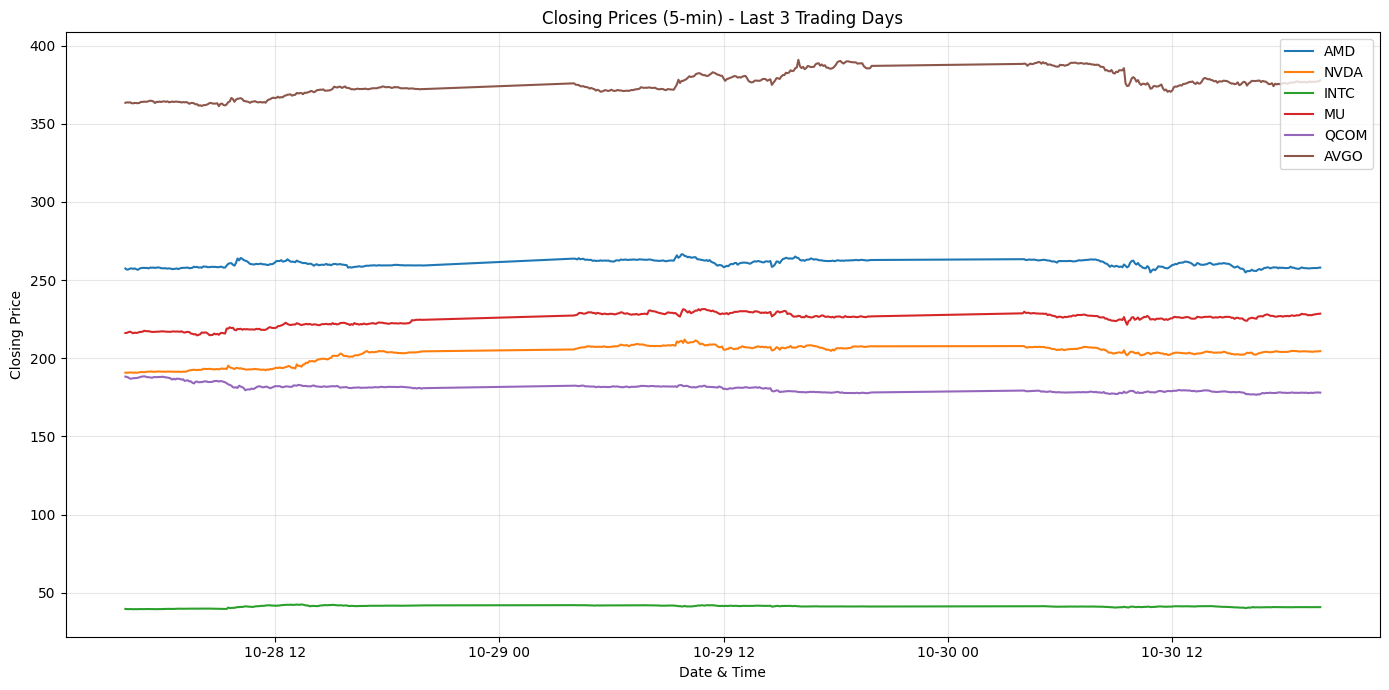


1. UNIT ROOT TEST (ADF) - STATIONARITY CHECK
AMD: ADF p-value = 0.036090 → Stationary
NVDA: ADF p-value = 0.182483 → Non-Stationary
INTC: ADF p-value = 0.140694 → Non-Stationary
MU: ADF p-value = 0.328828 → Non-Stationary
QCOM: ADF p-value = 0.102721 → Non-Stationary
AVGO: ADF p-value = 0.450751 → Non-Stationary

1.5 ORDER OF INTEGRATION (how many differences to stationarity)
AMD: d = 0  (p-value after differencing = 0.015588) → Stationary
NVDA: d = 1  (p-value after differencing = 0.000000) → Stationary
INTC: d = 1  (p-value after differencing = 0.000000) → Stationary
MU: d = 1  (p-value after differencing = 0.000000) → Stationary
QCOM: d = 1  (p-value after differencing = 0.000000) → Stationary
AVGO: d = 1  (p-value after differencing = 0.000000) → Stationary

Summary of integration orders:
  AMD: I(0)
  NVDA: I(1)
  INTC: I(1)
  MU: I(1)
  QCOM: I(1)
  AVGO: I(1)

2. JOHANSEN COINTEGRATION TEST (PAIRWISE)
AMD vs NVDA: Trace Stat = 16.05, Crit(5%) = 15.49 → COINTEGRATED
AMD vs INTC:

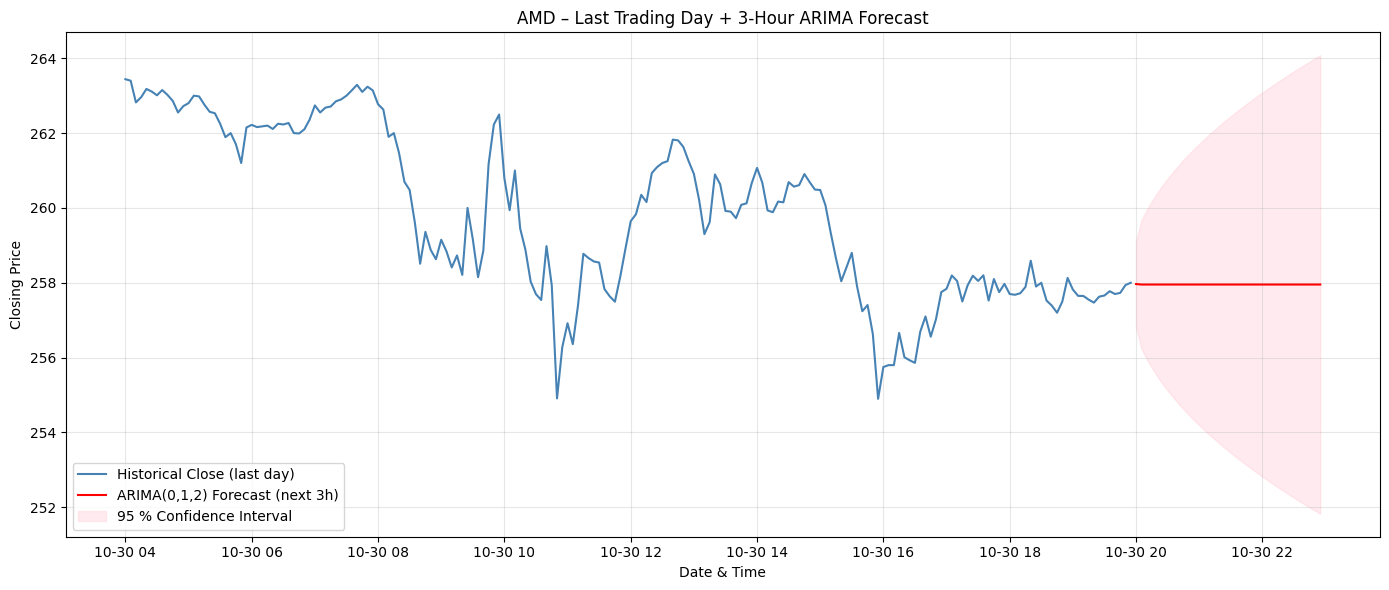


--- Processing NVDA ---
The results for the ARIMA(0,1,2) of NVDA are:
   AIC: 179.39
   Log-Likelihood: -86.69


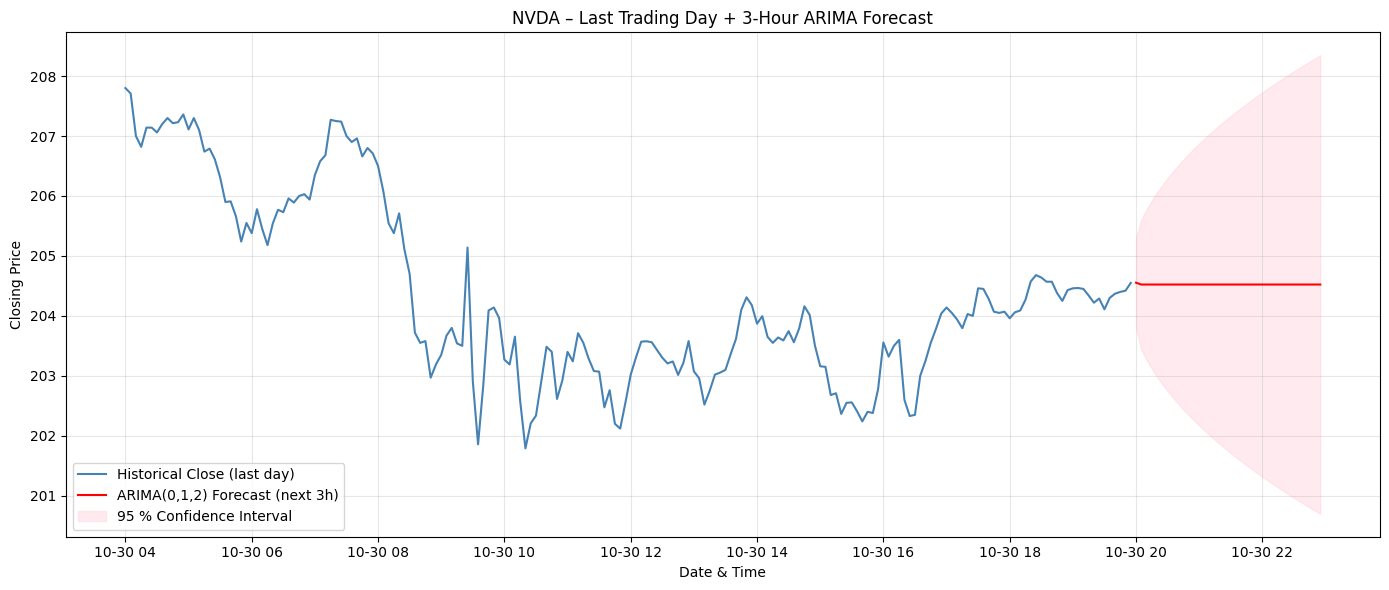


--- Processing INTC ---
The results for the ARIMA(0,1,2) of INTC are:
   AIC: -375.52
   Log-Likelihood: 190.76


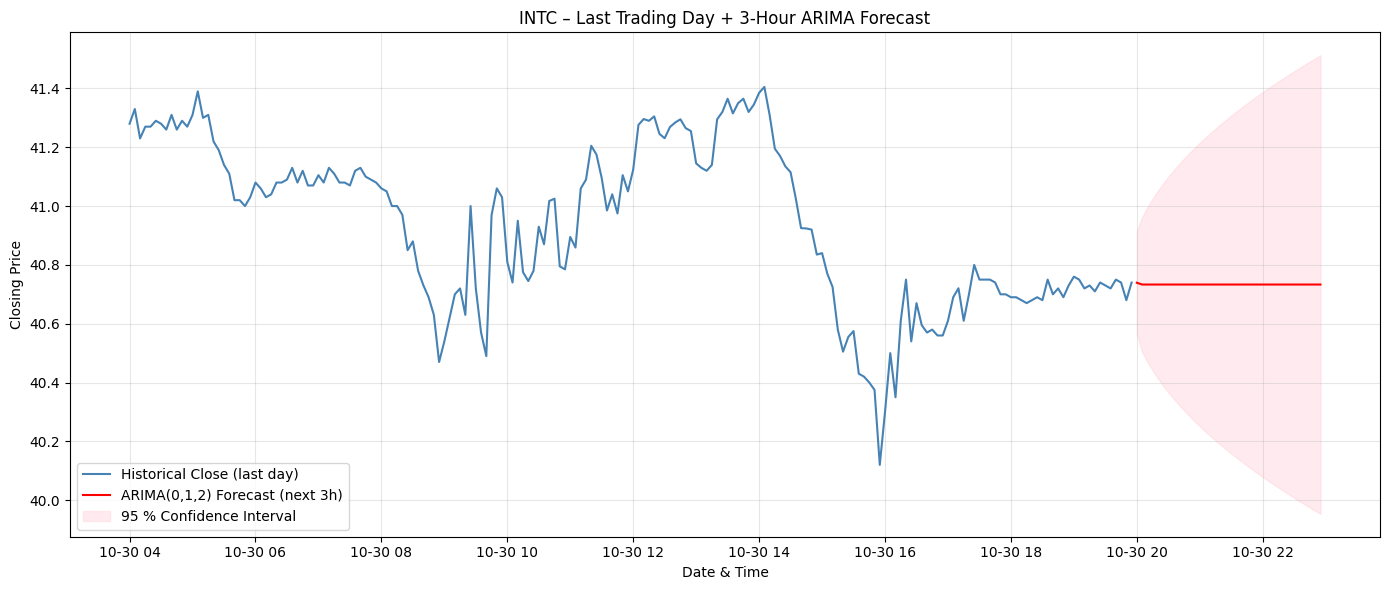


--- Processing MU ---
The results for the ARIMA(0,1,2) of MU are:
   AIC: 312.05
   Log-Likelihood: -153.03


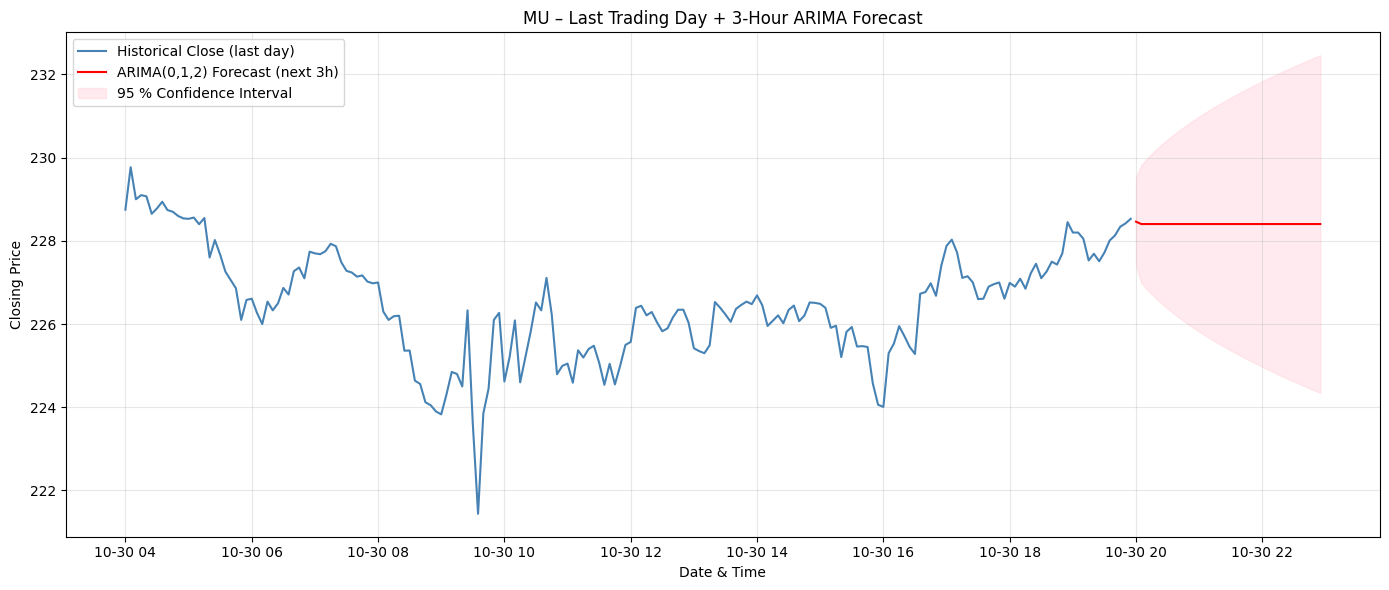


--- Processing QCOM ---
The results for the ARIMA(2,1,2) of QCOM are:
   AIC: 20.31
   Log-Likelihood: -5.16


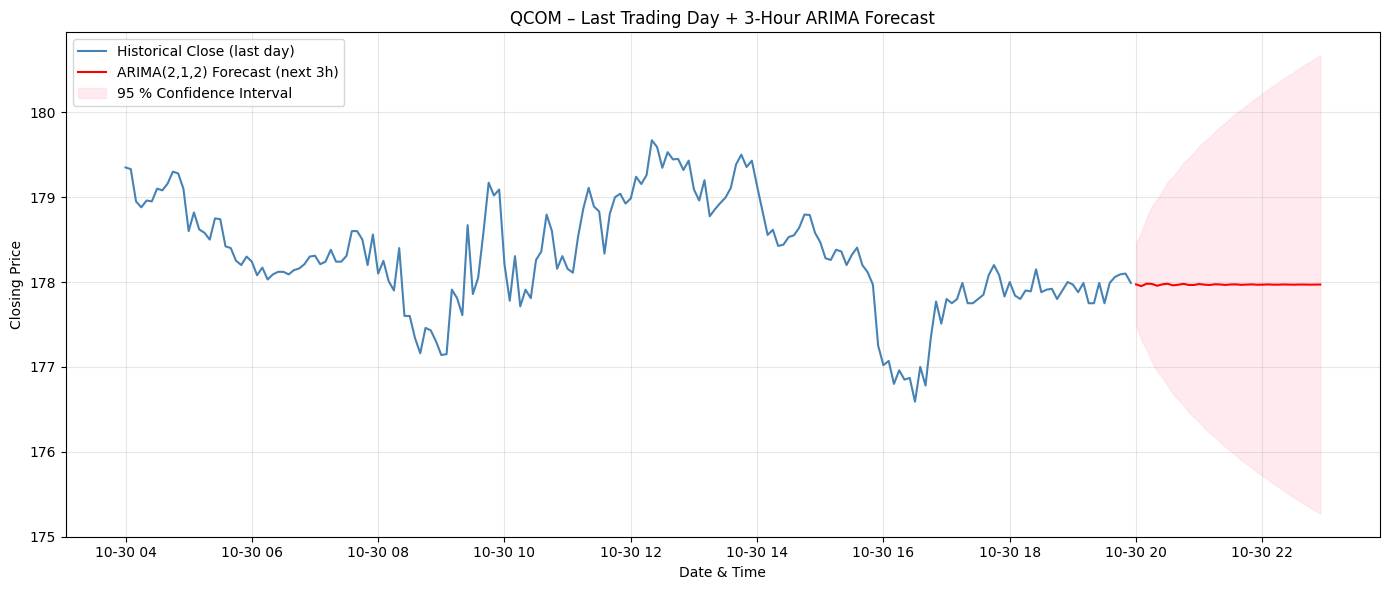


--- Processing AVGO ---
The results for the ARIMA(0,1,0) of AVGO are:
   AIC: 568.00
   Log-Likelihood: -283.00


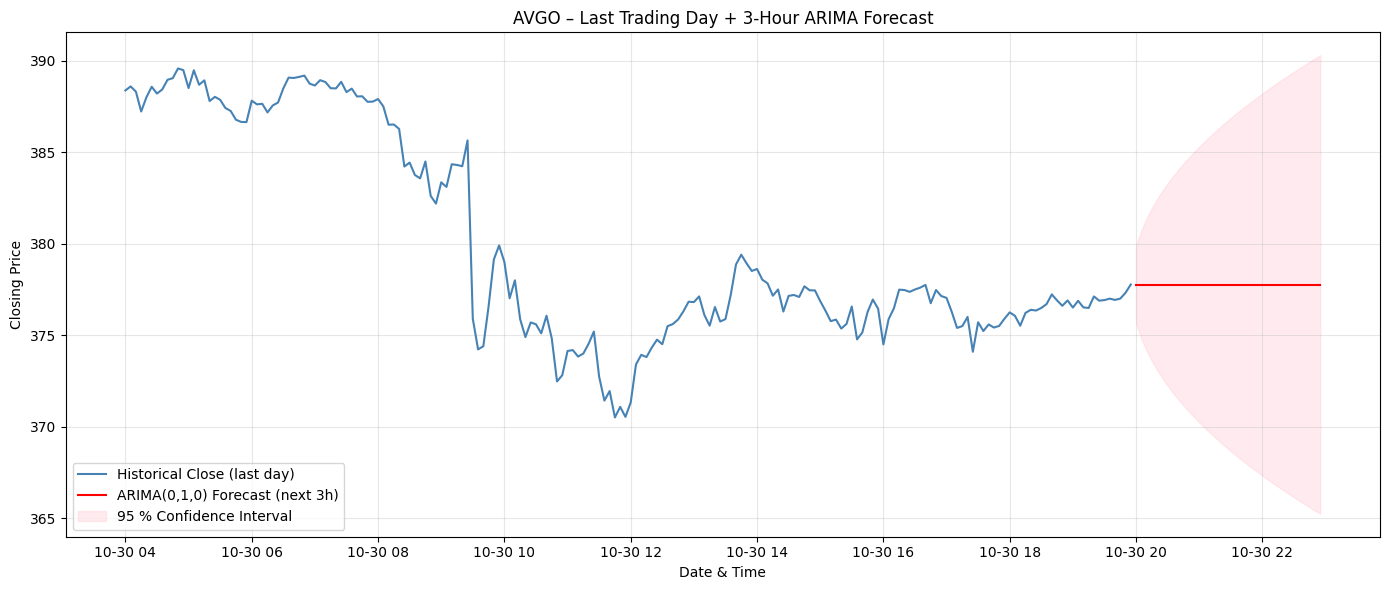

In [ ]:
# --------------------------------------------------------------
# 1. Install required packages (run once)
# --------------------------------------------------------------
!pip install -q alpha_vantage pandas matplotlib statsmodels scikit-learn

# --------------------------------------------------------------
# 2. Imports
# --------------------------------------------------------------
from alpha_vantage.timeseries import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.arima.model import ARIMA
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

# --------------------------------------------------------------
# 3. USER INPUT – 6 tickers
# --------------------------------------------------------------
tickers_input = input("Enter 6 stock tickers separated by commas (e.g. NVDA,AMD,AAPL,MSFT,GOOGL,TSLA): ").strip().upper()
tickers = [t.strip() for t in tickers_input.split(',') if t.strip()]
if len(tickers) != 6:
    raise ValueError("Please enter exactly 6 tickers.")
print(f"Selected tickers: {', '.join(tickers)}")

# --------------------------------------------------------------
# 4. Alpha Vantage setup
# --------------------------------------------------------------
api_key = "3DF7XEQ6SA0N9J9G"  # replace with your own key if desired
ts = TimeSeries(key=api_key, output_format='pandas')

# --------------------------------------------------------------
# 5. Download 5-minute data for all 6 stocks
# --------------------------------------------------------------
print("\nDownloading 5-minute data for all stocks...")
data_dict = {}
for ticker in tickers:
    print(f"  Downloading {ticker}...")
    data, meta = ts.get_intraday(symbol=ticker, interval='5min', outputsize='full')
    data.columns = ['open', 'high', 'low', 'close', 'volume']
    data.index = pd.to_datetime(data.index)
    data = data.sort_index()
    data_weekdays = data[data.index.weekday < 5]
    trading_days = data_weekdays.index.normalize().unique()[::-1]
    last_3_trading_days = sorted(trading_days[:3])
    if len(last_3_trading_days) < 3:
        print(f"Warning: Only {len(last_3_trading_days)} trading day(s) for {ticker}.")
        continue
    start_date = last_3_trading_days[0]
    end_date = last_3_trading_days[-1] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    last_3d = data_weekdays[start_date:end_date]
    data_dict[ticker] = last_3d['close'].copy()
    print(f"    {ticker}: {len(last_3d)} points from {last_3d.index.min()} to {last_3d.index.max()}")

# --------------------------------------------------------------
# 6. Align all series to same timestamp index
# --------------------------------------------------------------
print("\nAligning all time series to common timestamps...")
close_df = pd.DataFrame(data_dict)
close_df = close_df.dropna()  # Keep only timestamps where all 6 have data
print(f"Final aligned dataset: {len(close_df)} rows")

if len(close_df) == 0:
    raise ValueError("No overlapping timestamps across all 6 stocks.")

# --------------------------------------------------------------
# 7. Plot all closing prices in one line graph
# --------------------------------------------------------------
plt.figure(figsize=(14, 7))
for ticker in tickers:
    plt.plot(close_df.index, close_df[ticker], label=ticker)
plt.title('Closing Prices (5-min) - Last 3 Trading Days')
plt.xlabel('Date & Time')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# --------------------------------------------------------------
# 8. Unit Root Test (ADF) for stationarity
# --------------------------------------------------------------
print("\n" + "="*60)
print("1. UNIT ROOT TEST (ADF) - STATIONARITY CHECK")
print("="*60)
adf_results = {}
for ticker in tickers:
    series = close_df[ticker]
    result = adfuller(series)
    adf_results[ticker] = result
    p_value = result[1]
    print(f"{ticker}: ADF p-value = {p_value:.6f} → {'Stationary' if p_value < 0.05 else 'Non-Stationary'}")

# --------------------------------------------------------------
# 8.5 DETERMINE ORDER OF INTEGRATION (d) FOR EACH STOCK
# --------------------------------------------------------------
print("\n" + "="*60)
print("1.5 ORDER OF INTEGRATION (how many differences to stationarity)")
print("="*60)

def adf_pvalue(series):
    """Return ADF p-value (or 1.0 if error)"""
    try:
        return adfuller(series, maxlag=1, regression='c', autolag=None)[1]
    except:
        return 1.0

integration_order = {}

for ticker in tickers:
    series = close_df[ticker].copy()
    d = 0
    p_val = adf_pvalue(series)

    # keep differencing until p < 0.05 or d reaches a safe limit
    while p_val >= 0.05 and d < 3:          # stop at d=3 to avoid over-differencing
        d += 1
        series = series.diff().dropna()
        p_val = adf_pvalue(series)

    integration_order[ticker] = d
    status = "Stationary" if p_val < 0.05 else "Still Non-Stationary"
    print(f"{ticker}: d = {d}  (p-value after differencing = {p_val:.6f}) → {status}")

print("\nSummary of integration orders:")
for ticker, d in integration_order.items():
    print(f"  {ticker}: I({d})")

# --------------------------------------------------------------
# 9. Johansen Cointegration Test (pairwise)
# --------------------------------------------------------------
print("\n" + "="*60)
print("2. JOHANSEN COINTEGRATION TEST (PAIRWISE)")
print("="*60)

pair_combinations = list(combinations(tickers, 2))
cointegration_results = []

for pair in pair_combinations:
    t1, t2 = pair
    data_pair = close_df[[t1, t2]].dropna()
    if len(data_pair) < 50:
        print(f"Skipping {t1}-{t2}: insufficient data ({len(data_pair)} points)")
        continue
    try:
        johansen_result = coint_johansen(data_pair, det_order=0, k_ar_diff=1)
        trace_stat = johansen_result.lr1[0]  # Test for r=0 vs r>=1
        critical_value = johansen_result.cvt[0, 1]  # 5% critical value
        p_value = johansen_result.lr1[0]  # Approximate p-value not directly given
        is_cointegrated = trace_stat > critical_value
        cointegration_results.append((t1, t2, trace_stat, critical_value, is_cointegrated))
        status = "COINTEGRATED" if is_cointegrated else "Not cointegrated"
        print(f"{t1} vs {t2}: Trace Stat = {trace_stat:.2f}, Crit(5%) = {critical_value:.2f} → {status}")
    except Exception as e:
        print(f"Error testing {t1}-{t2}: {e}")

# --------------------------------------------------------------
# 10. ARIMA Modeling + Forecasting + Plot per stock (LAST DAY ONLY)
# --------------------------------------------------------------
print("\n" + "="*60)
print("3. ARIMA MODELING & FORECASTING (last trading day only)")
print("="*60)

# 3 hours = 36 × 5-min steps
forecast_steps = 36          # changed from 12

for ticker in tickers:
    print(f"\n--- Processing {ticker} ---")
    series = close_df[ticker].copy()

    # ------------------------------------------------------
    # 1. Keep only the last trading day
    # ------------------------------------------------------
    last_day = series.index.normalize()[-1]
    series_last_day = series[series.index.normalize() == last_day]

    # ------------------------------------------------------
    # 2. Auto-select ARIMA(p,d,q) – small grid (fast)
    # ------------------------------------------------------
    best_aic = np.inf
    best_order = None
    best_model = None

    for d in [0, 1]:
        diff_series = series_last_day.diff(d).dropna() if d > 0 else series_last_day
        for p in range(0, 3):
            for q in range(0, 3):
                try:
                    model = ARIMA(series_last_day, order=(p, d, q))
                    fitted = model.fit()
                    if fitted.aic < best_aic:
                        best_aic = fitted.aic
                        best_order = (p, d, q)
                        best_model = fitted
                except Exception:
                    continue

    if best_model is None:
        print(f"Could not fit ARIMA for {ticker}. Skipping.")
        continue

    p, d, q = best_order
    print(f"The results for the ARIMA({p},{d},{q}) of {ticker} are:")
    print(f"   AIC: {best_aic:.2f}")
    print(f"   Log-Likelihood: {best_model.llf:.2f}")

    # ------------------------------------------------------
    # 3. Forecast & confidence interval
    # ------------------------------------------------------
    forecast_result = best_model.get_forecast(steps=forecast_steps)
    forecast = forecast_result.predicted_mean
    conf_int = forecast_result.conf_int(alpha=0.05)

    # Future timestamps (5-min steps after the last observation)
    last_time = series_last_day.index[-1]
    future_index = pd.date_range(start=last_time + pd.Timedelta(minutes=5),
                                 periods=forecast_steps, freq='5min')

    # ------------------------------------------------------
    # 4. Plot last day + 3-hour forecast + 95 % CI
    # ------------------------------------------------------
    plt.figure(figsize=(14, 6))                     # a bit wider for longer horizon
    plt.plot(series_last_day.index, series_last_day,
             label='Historical Close (last day)', color='steelblue')
    plt.plot(future_index, forecast,
             label=f'ARIMA({p},{d},{q}) Forecast (next 3h)', color='red')
    plt.fill_between(future_index,
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     color='pink', alpha=0.3,
                     label='95 % Confidence Interval')

    plt.title(f'{ticker} – Last Trading Day + 3-Hour ARIMA Forecast')
    plt.xlabel('Date & Time')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()